In [1]:
from ftplib import FTP
import os
import zipfile
#import gzip
#import tarfile
from pprint import pprint
import io
import pandas
import numpy as np
import time
from IPython.display import display, HTML
import geopandas
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from shapely.ops import unary_union
from shapely.geometry import Point, Polygon, box
from matplotlib.patches import FancyBboxPatch, BoxStyle
import re
from matplotlib.path import Path

read_smaller_states = True

# #these_states_dict = {'FL': {}, 'MD': {}}
these_states_dict = {
    'IL': {},
    'PA': {},
            }

g = 0
scale = 20
map_buffer_ratio = .1
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "

equal_area_crs = 2163  # An equal area projection: https://epsg.io/2163
absolute_overlap_tol = 100    # tolerance for declaring areas overlapping, in sq meters
desired_pct_area_overlap = 0.5     # relative overlap to declare something a match

show_water = True
show_roads = False



water_area_tol = .5 * 1000 * 1000

#print('Target: each district should contain {0:,.0f} people!'.format(target))
print('ok')

ok


In [2]:
s = time.time()
script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
census_script_dir = '/home/idies/workspace/Storage/raddick/census/'
basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/'
shapefile_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2020/'
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

district_color_cycle = ['black', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
#district_color_cycle = ['black', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'purple', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_color_cycle += district_color_cycle
district_color_cycle += district_color_cycle

district_contrast_color_cycle = ['black', 'green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'red', 'red', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']
district_contrast_color_cycle += district_contrast_color_cycle
district_contrast_color_cycle += district_contrast_color_cycle

os.chdir(basedir)
e = time.time()
g += (e-s)
print('Now in directory: {0:}'.format(basedir))

Now in directory: /home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/


In [3]:
print('setting up infrastructure to plot roads...')
# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield



def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
        if ('Con' in annotator):
            annotator = '{0:}-C'.format(annotator[:-4])
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator


road_label_format = { 
    'I': { 'labelsize': 18, 'thecolor': 'red', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange'), 'labelcolor': 'white'},     
    'U': { 'labelsize': 16, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black'), 'labelcolor': 'black'},
    'S': { 'labelsize': 15, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black'), 'labelcolor': 'black'},
    'C': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white'), 'labelcolor': 'black'}, 
    'M': { 'labelsize': 16, 'thecolor': 'black', 'labelcolor': 'black'},
    'O': { 'labelsize': 11, 'thecolor': 'black', 'labelcolor': 'black'},
    'x': { 'labelsize': 10, 'thecolor': 'gray', 'labelcolor': 'gray'},
}
print('Done!')



setting up infrastructure to plot roads...
Done!


In [4]:
s = time.time()
# print('Getting data from FTP...')

# ftp = FTP('ftp2.census.gov')
# ftp.login()
# print(ftp.getwelcome())

# ftp.cwd('programs-surveys/decennial/2020/data/01-Redistricting_File--PL_94-171/')
# for thisdir in [x for x in ftp.nlst() if (('.pdf' not in x) and ('.doc' not in x))]:
#     print('Retrieving {0:}...'.format(thisdir))
#     zipfiles = [x for x in ftp.nlst(thisdir)]
#     for thisfile in zipfiles:
#         with io.open(thisfile.split('/')[1].lower(), 'wb') as f:
#              ftp.retrbinary('RETR {0:}'.format(thisfile), f.write)
# ftp.quit()
# print('Done')

# os.listdir()
#os.getcwd()
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Retrieved files from Census FTP!')

Retrieved files from Census FTP!


In [5]:
s = time.time()
# for thisfile in os.listdir():
#     with zipfile.ZipFile(thisfile, 'r') as z:
#         print('Extracting {0:}...'.format(thisfile))
#         z.extractall()
# for thisfile in [x for x in os.listdir() if ('zip' in x)]:
#     os.remove(thisfile)
# print('Done!')
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Unzipped files!')

Unzipped files!


# How many districts per state?

In [6]:
state_seats_df = pandas.read_csv(script_dir+'state_seats.csv', index_col='state_name')

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
#state_codes_df.columns = [x.lower() for x in state_codes_df.columns]
state_codes_df = state_codes_df.set_index('STATE_NAME')

#bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# state_seats_df = state_seats_df.reset_index().merge(
#     geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']], how='left', 
#     left_on='state_name', right_on='NAME'
# )[['STATE', 'STUSAB', 'seats_old', 'seats_new']].set_index('STATE').sort_index()

# print('Found new numbers of districts for {0:,.0f} states!'.format(len(state_seats_df)))
#state_seats_df
#geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']]

state_seats_df = state_seats_df.join(state_codes_df).set_index('STATE').sort_index()

print('Got old and new numbers of districts for {0:,.0f} states in {1:.1f} seconds!'.format(len(state_seats_df), e-s))

for this_state in these_states_dict.keys():
    these_states_dict[this_state]['STATEFP'] = state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]    
    these_states_dict[this_state]['seats_old'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_old'].values[0]
    these_states_dict[this_state]['seats_new'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_new'].values[0]
#pprint(these_states_dict)
print('\n')
print('Got old and new numbers of districts for {0:,.0f} focus states in {1:.1f} seconds!'.format(len(these_states_dict), e-s))



looking up state names from numbers...
Got old and new numbers of districts for 50 states in 0.0 seconds!


Got old and new numbers of districts for 2 focus states in 0.0 seconds!


# Read summary levels

In [7]:
s = time.time()
print('setting up summary levels...')
sumlevel_df = pandas.read_excel(script_dir+'sumlevel.xlsx')
sumlevel_df = sumlevel_df.rename(columns={'sumlevel': 'SUMLEV'})
sumlevel_df.index.name = 'rownumber'
#sumlevel_df = sumlevel_df.set_index('SUMLEV')
e = time.time()
g += (e-s)
print('Read descriptions for {0:,.0f} summary levels in {1:.1f} seconds!'.format(len(sumlevel_df), e-s))
#sumlevel_df


setting up summary levels...
Read descriptions for 85 summary levels in 0.1 seconds!


# Read redistricting geo data

In [8]:
s = time.time()
print('reading redistricting geography data for all states...')
geofiles = []

allgeofiles = [x for x in os.listdir() if (('geo' in x) and (x[-3:] == '.pl') and (x[:2] not in ['dc', 'pr', 'mp', 'vi', 'as', 'gu']))]
for this_focus_state in list(these_states_dict.keys()):
    geofiles += [x for x in allgeofiles if x[0:2] == this_focus_state.lower()]
    #geofiles.append([x for x in geofiles if x[0:2] == this_focus_state.lower()])

geo_df = pandas.DataFrame()

for thisfile in geofiles:
    print('\treading {0:}...'.format(thisfile))
    geo_df_i = pandas.read_csv(thisfile, sep='|', header=None, low_memory=False, encoding='ISO-8859-1')#, encoding='utf-8')
    geo_df = pandas.concat((geo_df, geo_df_i), axis=0)
    
print('renaming columns...')
column_names = []
column_names += ['FILEID', 'STUSAB', 'SUMLEV', 'GEOVAR', 'GEOCOMP', 'CHARITER', 'CIFSN', 'LOGRECNO', 'GEOID']
column_names += ['GEOCODE', 'REGION', 'DIVISION', 'STATE', 'STATENS', 'COUNTY', 'COUNTYCC', 'COUNTYNS']
column_names += ['COUSUB', 'COUSUBCC', 'COUSUBNS']
column_names += ['SUBMCD', 'SUBMDCC', 'SUBMCDNS', 'ESTATE', 'ESTATECC', 'ESTATENS']
column_names += ['CONCIT', 'CONCITCC', 'CONCITNS', 'PLACE','PLACECC', 'PLACENS']
column_names += ['TRACT', 'BLKGRP', 'BLOCK']
column_names += ['AIANHH', 'AIANHHLI', 'AIANHHFP', 'AIANHHCC', 'AIANHHNS', 'AITS', 'AITSFP', 'AITSCC', 'AITSNS']
column_names += ['TTRACT', 'TBLKGRP', 'ANRC', 'ANRCCC', 'ARNCNS']
column_names += ['CBSA', 'MEMI', 'CSA', 'METDIV']
column_names += ['NECTA', 'NMEMI', 'CNECTA', 'NECTADIV']
column_names += ['CBSAPCI', 'NECTAPCI', 'UA', 'UATYPE', 'UR']
column_names += ['CD116', 'CD118', 'CD119', 'CD120', 'CD121']
column_names += ['SLDU18', 'SLDU22', 'SLDU24', 'SLDU26', 'SLDU28']
column_names += ['SLDL18', 'SLDL22', 'SLDL24', 'SLDL26', 'SLDL28']
column_names += ['VTD', 'VTDI', 'ZCTA', 'SDELM', 'SDSEC', 'SDUNI', 'PUMA']
column_names += ['AREALAND', 'AREAWATER', 'BASENAME', 'NAME', 'FUNCSTAT', 'GCUNI']
column_names += ['POP100', 'HU100']
column_names += ['INTPTLAT', 'INTPTLON', 'LSADC', 'PARTFLAG', 'UGA']

# for i in range(0, len(column_names)):    
#     if (np.isnan(pandas.to_numeric(column_names[i], errors='coerce'))):
#         geo_df = geo_df.rename(columns = {i: column_names[i]})
#     else:
#         geo_df = geo_df.rename(columns = {i: int(column_names[i])})

geo_df.columns = column_names

print('\tTotal columns: {0:.0f}'.format(len(geo_df.columns)))
print('\tNamed columns: {0:.0f}'.format(len(column_names)))

geo_df = geo_df.set_index('GEOID')


# print('finding stuff...')
# mycol = 'UGA'
# showcolumns = []
# showcolumns += ['SUMLEV', mycol]
#geo_df[geo_df[mycol].notnull()][showcolumns]
#print('done')

# geo_df.merge(sumlevel_df, how='left', on='SUMLEV')
# geo_df.set_index('SUMLEV')
# print('adding summary level descriptions...')
# geo_df = geo_df.reset_index().merge(sumlevel_df, how='left', on='SUMLEV').set_index('GEOID')
# geo_df = geo_df.rename(columns={'description': 'sumlev_description'})

#geo_df
e = time.time()
g += (e-s)
print('\n')
print('Read {0:,.0f} geographies in {1:.0f} minutes {2:.0f} seconds!'.format(len(geo_df), np.floor((e-s)/60), (e-s)%60))


reading redistricting geography data for all states...
	reading ilgeo2020.pl...
	reading pageo2020.pl...
renaming columns...
	Total columns: 97
	Named columns: 97


Read 1,143,454 geographies in 0 minutes 47 seconds!


In [9]:
s = time.time()
print('counting by summary level...')
count_df = pandas.DataFrame(data=None, columns=['sumlev_description', 'count', 'pop'], index=sumlevel_df['SUMLEV'].tolist())
count_df.index.name = 'SUMLEV'
count_df.loc[:, 'sumlev_description'] = sumlevel_df.set_index('SUMLEV')['description']
count_df.loc[:, 'count'] = geo_df.groupby('SUMLEV').size()
count_df.loc[:, 'pop'] = geo_df.groupby('SUMLEV')['POP100'].sum()
#count_df
nan_levels = count_df[count_df['count'].isnull()].index.tolist()

htmlstr = ''
htmlstr += '<table>'
htmlstr += '<tr>'
htmlstr += '<th>SUMLEVEL</th>'
for thiscol in count_df.columns.tolist():    
    htmlstr += '<th>{0:}</th>'.format(thiscol)
htmlstr += '</tr>'

for sumlev, thisrow in count_df.iterrows():
    #if ('remainder' not in thisrow['sumlev_description'].lower()):
    if (sumlev not in nan_levels):
        htmlstr += '<tr>'    
        htmlstr += '<td>{0:3d}</td><td>{1:}</td><td>{2:,.0f}</td><td>{3:,.0f}</td>'.format(sumlev, thisrow['sumlev_description'], thisrow['count'], thisrow['pop'])
        htmlstr += '</tr>'
htmlstr += '</table>'

# print('No data for these columns: {0:}'.format(nan_levels))
# display(HTML(htmlstr))

e = time.time()
g += (e-s)
print('\n')
print('Documented {0:,.0f} geographies in {1:.1f} seconds!'.format(len(count_df), e-s))



counting by summary level...


Documented 85 geographies in 0.1 seconds!


In [10]:
s = time.time()
print('Getting current Congressional District data...')
cd_df = geo_df[geo_df['SUMLEV'] == 500]
cd_df = cd_df[cd_df['CD116'] != 'ZZ']
cd_df.loc[:, 'CD116'] = pandas.to_numeric(cd_df['CD116'], errors='coerce')
cd_df.loc[cd_df['CD116'] == 0, 'CD116'] = 1

print('adding shapefiles...')
gdf = geopandas.read_file(shapefile_basedir+'CD/tl_2020_us_cd116.shp')
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '5001600US'+x)
gdf = gdf.set_index('GEOID')

cd_gdf = geopandas.GeoDataFrame(data=cd_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')
#cd_gdf

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} congressional districts to shapefiles in {1:.1f} seconds!'.format(len(cd_gdf), e-s))
#cd_gdf[['STATE', 'STUSAB']].drop_duplicates()
#cd_gdf.plot()
# print(cd_gdf.groupby('CD116')['POP100'].sum())
# print('\n')
# print(cd_gdf.groupby('STUSAB')['POP100'].sum())
# print('\n')
# print('{0:,.0f}'.format(cd_gdf['POP100'].sum()))


Getting current Congressional District data...
adding shapefiles...


Joined 36 congressional districts to shapefiles in 6.1 seconds!


In [11]:
print('getting tract data...')
s = time.time()
tract_df = geo_df[geo_df['SUMLEV'] == 140]
tract_df = tract_df.assign(census_tract = tract_df['TRACT'].apply(lambda x: x/100))
#tract_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
tract_df = tract_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
county_names_df = county_names_df.reset_index(drop=True)
tract_df = tract_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

print('adding empty column for new districts...')
tract_df = tract_df.assign(new_district = np.nan)

print('adding shapefiles...')
gdf = geopandas.GeoDataFrame()
for this_state in tract_df['STATE'].drop_duplicates().tolist():
    print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
    gdf_i = geopandas.read_file(shapefile_basedir+'TRACT/tl_2020_{0:02d}_tract.shp'.format(this_state))
    #print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
    gdf = pandas.concat((gdf, gdf_i), axis=0)
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1400000US'+x)
gdf = gdf.set_index('GEOID')
tract_gdf = geopandas.GeoDataFrame(data=tract_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')


#state_codes_df
#tract_df = tract_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} tracts to shapefiles in {1:.1f} seconds!'.format(len(tract_gdf), e-s))



getting tract data...
looking up state names from numbers...
looking up county names from numbers...
adding empty column for new districts...
adding shapefiles...
	getting shapefiles for IL...
	getting shapefiles for PA...


Joined 6,711 tracts to shapefiles in 12.6 seconds!


In [12]:
# print('getting block group data...')
# s = time.time()
# bg_df = geo_df[geo_df['SUMLEV'] == 150]
# bg_df = bg_df.assign(census_tract = bg_df['TRACT'].apply(lambda x: x/100))
# #bg_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

# print('looking up state names from numbers...')
# state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
# bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


# print('looking up county names from numbers...')
# county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
# county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
# county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
# county_names_df = county_names_df.reset_index(drop=True)
# bg_df = bg_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

# print('adding empty column for new districts...')
# bg_df = bg_df.assign(new_district = np.nan)

# print('adding shapefiles...')
# gdf = geopandas.GeoDataFrame()
# for this_state in bg_df['STATE'].drop_duplicates().tolist():
#     print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
#     gdf_i = geopandas.read_file(shapefile_basedir+'BG/tl_2020_{0:02d}_bg.shp'.format(this_state))
#     print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
#     gdf = pandas.concat((gdf, gdf_i), axis=0)
# gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1500000US'+x)
# gdf = gdf.set_index('GEOID')
# bg_gdf = geopandas.GeoDataFrame(data=bg_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')




# #state_codes_df
# #bg_df = bg_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# e = time.time()
# g += (e-s)
# print('\n')
# print('Joined {0:,.0f} block groups to shapefiles in {1:.1f} seconds!'.format(len(bg_gdf), e-s))




In [13]:
s = time.time()
this_state = 'PA'

state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

print('getting states...')
state_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
state_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(state_gdf['INTPTLON'])
state_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(state_gdf['INTPTLAT'])
state_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_gdf['STATEFP'], errors='coerce')
#state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
state_gdf = state_gdf.set_index('GEOID')

print('getting counties...')
county_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_county.shp')
county_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(county_gdf['STATEFP'], errors='coerce')
county_gdf.loc[:, 'COUNTYNS'] = pandas.to_numeric(county_gdf['COUNTYNS'], errors='coerce')
county_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(county_gdf['INTPTLON'])
county_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(county_gdf['INTPTLAT'])
#county_gdf = county_gdf[county_gdf['STATEFP'].isin(state_numbers_include_list)]
county_gdf = county_gdf.set_index('GEOID')

e = time.time()
g += (e-s)
print('Got {0:,.0f} states and {1:,.0f} counties in {2:.1f} seconds!'.format(len(state_gdf), len(county_gdf), e-s))
print('\n')


if (show_water):
    print('getting water areas...')

    waterfiles = [shapefile_basedir+'AREAWATER/'+x for x in os.listdir(shapefile_basedir+'AREAWATER/') if ((x[-4:] == '.shp') )]
    state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
    state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

    waterfiles = [x for x in waterfiles if x[89:91] in state_numbers_include_list]

    water_gdf = geopandas.GeoDataFrame()

    for i in range(0, len(waterfiles)):
        if (np.mod(i, 10) == 0):
            print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i, len(waterfiles)))
        water_gdf_i = geopandas.read_file(waterfiles[i])
        water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf_i = water_gdf_i.assign(STUSAB = state_codes_df[state_codes_df['STATE'] == int(waterfiles[i][89:91])]['STUSAB'].values[0])
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0)
    water_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(water_gdf['INTPTLON'], errors='coerce')
    water_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(water_gdf['INTPTLAT'], errors='coerce')
    water_gdf = water_gdf.set_index('HYDROID')
    
    e = time.time()
    g += (e-s)

    print('Got {0:,.0f} water areas in {1:.0f} minutes {2:.1f} seconds!'.format(len(water_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


s = time.time()
print('getting CBSAs (metro areas)...')
cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])
cbsa_gdf.loc[:, 'MEMI'] = pandas.to_numeric(cbsa_gdf['MEMI'])
cbsa_gdf = cbsa_gdf.set_index('GEOID')

print('\tFinding populations of CBSAs...')
cbsa_gdf = cbsa_gdf.assign(POP100 = np.nan)
for ix, thisrow in cbsa_gdf.sort_values(by='NAME').iterrows():
    cbsa_gdf.loc[ix, 'POP100'] = tract_gdf[(tract_gdf['COUNTYNS'].isin(county_gdf[county_gdf.geometry.within(thisrow.geometry)]['COUNTYNS'].tolist()))]['POP100'].sum()
    if (this_state in thisrow['NAME']):
        print('\t\t{0:} (n = {1:,.0f})...'.format(thisrow['NAME'], cbsa_gdf.loc[ix]['POP100']))
cbsa_gdf.loc[cbsa_gdf[cbsa_gdf['POP100'] == 0].index.tolist(), 'POP100'] = np.nan

e = time.time()
g += (e-s)
print('Got {0:,.0f} CBSAs in {1:.1f} seconds!'.format(len(cbsa_gdf), e-s))
print('\n')
s = time.time()
print('getting places...')
placefiles = [shapefile_basedir+'PLACE/'+x for x in os.listdir(shapefile_basedir+'PLACE/') if ((x[-4:] == '.shp'))]
placefiles = [x for x in placefiles if x[85:87] in state_numbers_include_list]

place_gdf = geopandas.GeoDataFrame()

for i in range(0, len(placefiles)):
    if (np.mod(i, 5) == 0):
        print('\treading place file {0:,.0f} of {1:,.0f}...'.format(i, len(placefiles)))
    place_gdf_i = geopandas.read_file(placefiles[i])
    place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0)
place_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(place_gdf['STATEFP'])
place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'])
place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'])

place_gdf.loc[:, 'GEOID'] = place_gdf['GEOID'].apply(lambda x: '1600000US'+x)
place_gdf = place_gdf.set_index('GEOID')
e = time.time()
g += (e-s)
print('Got {0:,.0f} places in {1:.1f} seconds!'.format(len(place_gdf), e-s))
print('\n')

if (show_roads):
    print('getting roads...')
    roads_gdf = geopandas.GeoDataFrame()
#    print(os.listdir(shapefile_basedir+'ROADS/'))
    roads_file_list = [shapefile_basedir+'ROADS/'+x for x in os.listdir(shapefile_basedir+'ROADS/') if ((x[-4:] == '.shp') and (x[8:10] in state_numbers_include_list))]# and ('_{0:02d}'.format()))]# and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(roads_file_list)):
        if ((np.mod(i,10) == 0) | (i == len(roads_file_list)-1)):
            print('\tReading road file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
        roads_gdf_i = geopandas.read_file(roads_file_list[i])    
        roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)
    roads_gdf = roads_gdf.set_index('LINEARID')
    e = time.time()
    g += (e-s)
    print('Got {0:,.0f} roads in {1:.0f} minutes {2:.1f} seconds!'.format(len(roads_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


print('Done!')


cbsa_gdf[cbsa_gdf['NAME'].apply(lambda x: this_state in x)][['NAME', 'POP100']].sort_values(by='POP100', ascending=False)


getting states...
getting counties...
Got 56 states and 3,234 counties in 6.3 seconds!


getting water areas...
	reading water file 0 of 169...
	reading water file 10 of 169...
	reading water file 20 of 169...
	reading water file 30 of 169...
	reading water file 40 of 169...
	reading water file 50 of 169...
	reading water file 60 of 169...
	reading water file 70 of 169...
	reading water file 80 of 169...
	reading water file 90 of 169...
	reading water file 100 of 169...
	reading water file 110 of 169...
	reading water file 120 of 169...
	reading water file 130 of 169...
	reading water file 140 of 169...
	reading water file 150 of 169...
	reading water file 160 of 169...
Got 808 water areas in 0 minutes 34.1 seconds!


getting CBSAs (metro areas)...
	Finding populations of CBSAs...
		Allentown-Bethlehem-Easton, PA-NJ (n = 752,257)...
		Altoona, PA (n = 122,822)...
		Bloomsburg-Berwick, PA (n = 82,863)...
		Bradford, PA (n = 40,432)...
		Chambersburg-Waynesboro, PA (n = 155,932)...
		DuB

,NAME,POP100
GEOID,,
37980,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",4218131.0
38300,"Pittsburgh, PA",2370930.0
10900,"Allentown-Bethlehem-Easton, PA-NJ",752257.0
25420,"Harrisburg-Carlisle, PA",591712.0
42540,"Scranton--Wilkes-Barre, PA",567559.0
29540,"Lancaster, PA",552984.0
49620,"York-Hanover, PA",456438.0
39740,"Reading, PA",428849.0
21500,"Erie, PA",270876.0


In [14]:

# s = time.time()
# print('setting up insets...')
# insets = {}

# insets['se'] = {}
# insets['se']['how'] = 'districts'
# insets['se']['bounds'] = [-80.48, 25.54, -80, 26.84]
# insets['se']['axes_position'] = [0.3, 0.01]
# insets['se']['axes_rel_size'] = .255
# insets['se']['districts'] = [21,22,23,24,27]
# insets['se']['partial_districts'] = [18,20,25,26]
# insets['se']['counties'] = ['Palm Beach County', 'Broward County', 'Miami-Dade County']
# insets['se']['title'] = 'Southeast Florida'
# insets['se']['titlesize'] = 22
# insets['se']['borderwidth'] = 3

# insets['tpa'] = {}
# insets['tpa']['how'] = 'districts'
# #insets['tpa']['bounds'] = [-82.85, 27.6, -82, 28.2]
# insets['tpa']['bounds'] = [-82.9, 27.6, -82.18, 28.2]
# insets['tpa']['axes_position'] = [0.03, 0.015]
# insets['tpa']['axes_rel_size'] = 0.255
# insets['tpa']['districts'] = [13,14]
# insets['tpa']['partial_districts'] = [12, 15, 16]
# insets['tpa']['counties'] = ['Hillsborough County', 'Pinellas County']
# insets['tpa']['title'] = 'Tampa Bay'
# insets['tpa']['titlesize'] = 22
# insets['tpa']['borderwidth'] = 3

# insets['orl'] = {}
# insets['orl']['how'] = 'counties'
# insets['orl']['bounds'] = [-81.68, 28.33, -80.82, 28.88]

# insets['orl']['axes_position'] = [0.03, 0.26]
# insets['orl']['axes_rel_size'] = 0.255
# insets['orl']['districts'] = [7,10]
# insets['orl']['partial_districts'] = [6,8,9,11,15]
# insets['orl']['counties'] = ['Orange County', 'Seminole County']
# insets['orl']['title'] = 'Orlando'
# insets['orl']['titlesize'] = 22
# insets['orl']['borderwidth'] = 3

# insets['jax'] = {}
# insets['jax']['how'] = 'counties'
# insets['jax']['axes_position'] = [0.84, 0.87]
# insets['jax']['axes_rel_size'] = 0.15
# insets['jax']['districts'] = [4,5]
# insets['jax']['partial_districts'] = [3]
# insets['jax']['counties'] = ['Duval County']
# insets['jax']['title'] = 'Jacksonville'
# insets['jax']['titlesize'] = 22
# insets['jax']['borderwidth'] = 3

# insets['tally'] = {}
# insets['tally']['how'] = 'places'
# insets['tally']['axes_position'] = [0.84, 0.69]
# insets['tally']['axes_rel_size'] = 0.15
# insets['tally']['districts'] = [2,5]
# insets['tally']['partial_districts'] = []
# insets['tally']['counties'] = ['Leon County']
# insets['tally']['places'] = ['Tallahassee']
# insets['tally']['title'] = 'Tallahassee'
# insets['tally']['titlesize'] = 22
# insets['tally']['borderwidth'] = 3


# for inset_name, inset in insets.items():
#     print(inset_name)
    
#     if ('bounds' in inset.keys()):
#         inset['aspect_ratio'] = (inset['bounds'][2] - inset['bounds'][0]) / (inset['bounds'][3] - inset['bounds'][1])
#     else:
#         if (inset['how'] == 'districts'):
#             thegeo = unary_union(cd_gdf[cd_gdf['CD116'].isin(inset['districts'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'counties'):
#             thegeo = unary_union(tract_gdf[tract_gdf['COUNTY_NAME'].isin(inset['counties'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'places'):
#             thegeo = unary_union(place_gdf[place_gdf['NAME'].isin(inset['places'])].geometry.tolist()).bounds
#         xlims = [thegeo[0], thegeo[2]]
#         ylims = [thegeo[1], thegeo[3]]        
#         xspan = xlims[1] - xlims[0]
#         yspan = ylims[1] - ylims[0]
#         inset['aspect_ratio'] = xspan / yspan
#         xlims[0] = xlims[0] - (map_buffer_ratio * xspan)
#         ylims[0] = ylims[0] - (map_buffer_ratio * yspan)
#         xlims[1] = xlims[1] + (map_buffer_ratio * xspan)
#         ylims[1] = ylims[1] + (map_buffer_ratio * yspan)    
#         inset['bounds'] = [xlims[0], ylims[0], xlims[1], ylims[1]]
#         print(inset['bounds'])
    
#     inset['box_gdf'] = geopandas.GeoDataFrame(data=[[
#         box(
#             inset['bounds'][0], 
#             inset['bounds'][1], 
#             inset['bounds'][2], 
#             inset['bounds'][3]
#         )]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')    
#     inset['axes_size'] = [inset['axes_rel_size'], inset['axes_rel_size'] / inset['aspect_ratio']]
# #    print(inset['axes_size'])

# all_inset_districts = []
# for inset in insets.values():
#     all_inset_districts += inset['districts']
# main_map_districts = [x for x in list(range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_old']+1)) if x not in all_inset_districts]

# main_map_districts += [x for x in insets['jax']['districts']]
# main_map_districts += [x for x in insets['tally']['districts']]
# main_map_districts = sorted(main_map_districts)

# #print(main_map_districts)
# e = time.time()
# g += (e-s)
# print('Done!')
# #main_map_districts


main map...
	reprojecting...
	plotting...
		Plotting IL...
		Plotting PA...
	plotting census tracts...
AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...
Done plotting in 38 seconds!


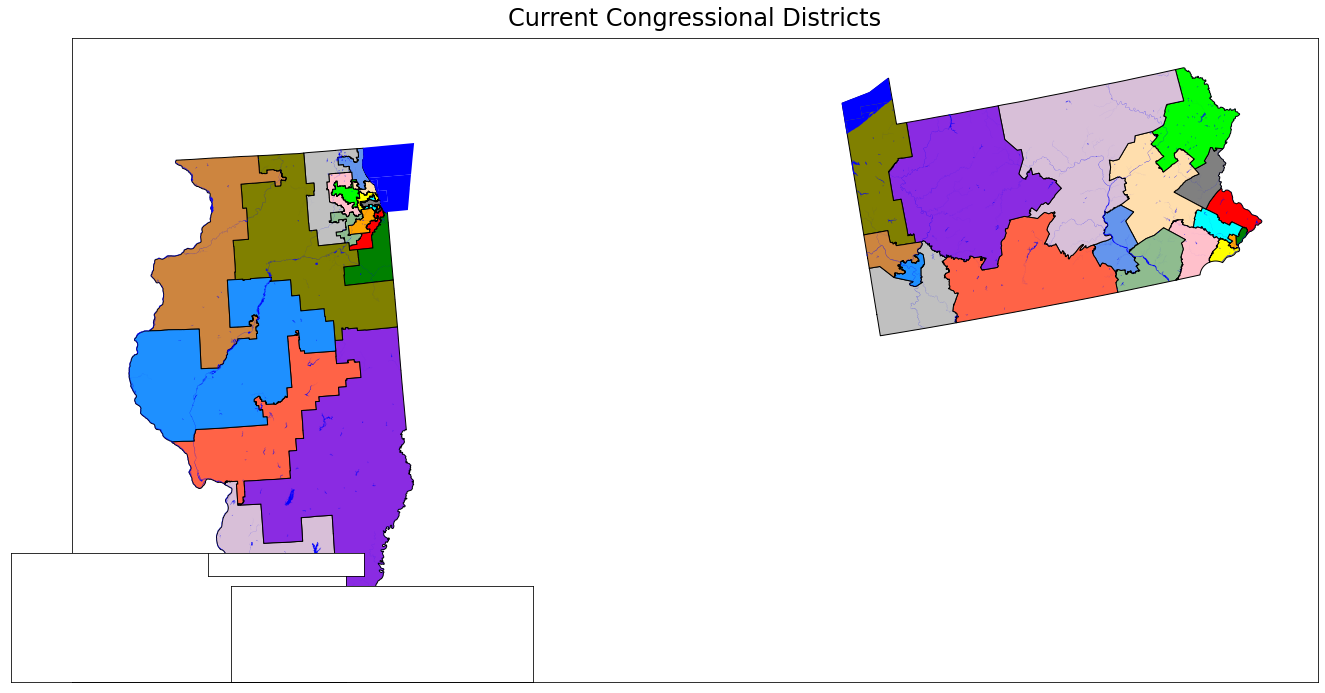

In [15]:
s = time.time()
# main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
# alaska_crs = "epsg:3338"
# hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = True

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].tolist():#.sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    cdlist = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(cdlist)+1):
        cd_gdf[
            (cd_gdf['STUSAB'] == this_state) 
            & (cd_gdf['CD116'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
#         annotator = i
#         this_district_geo = unary_union(cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == i)].to_crs(main_map_crs).geometry.tolist())
#         centerpoint = (this_district_geo.centroid.x, this_district_geo.centroid.y)
#         ax.annotate(annotator, centerpoint, 
#                     color='black', backgroundcolor='white', ha='center', va='center', fontsize=20)

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STUSAB'].apply(lambda x: x not in ['AK','HI'])].to_crs(main_map_crs).plot(ax=ax, color='blue', edgecolor='none', linewidth=0.5)



    
#ax.legend(handles=legend_list, fontsize=10)


if (len(list(these_states_dict.keys())) == 1):
    ax.set_title('Current {0:} Congressional Districts (n = {1:.0f})'.format(
        list(these_states_dict.keys())[0], 
        these_states_dict[list(these_states_dict.keys())[0]]['seats_old']
    ), fontsize=24, y=1.01)
else:
    ax.set_title('Current Congressional Districts', fontsize=24, y=1.01)

# # # # ax.tick_params(axis='both', labelsize=20)

# # # # # print('saving figure...')
# # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # #plt.show()
# # e = time.time()
# # g += (e-s)
# # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'AK']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'HI']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'HI') & (cd_gdf['CD116'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

for thisax in [ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

# print('saving figure...')
# fig.savefig(script_dir+'all-districts-orig.jpg', format='jpg', dpi=300, bbox_inches='tight')
#plt.show()
e = time.time()
g += (e-s)
print('Done plotting in {0:,.0f} seconds!'.format(e-s))

# How many districts in each state?

In [16]:
for this_state_name, this_state in these_states_dict.items():
    if (this_state['seats_new'] == 1):
        these_states_dict[this_state_name]['target'] = -1
    else:
        these_states_dict[this_state_name]['target'] = cd_gdf[cd_gdf['STUSAB'] == this_state_name]['POP100'].sum() / this_state['seats_new']
    
    
these_states_dict
#water_gdf.head(1).T

{'IL': {'STATEFP': 17,
  'seats_old': 18,
  'seats_new': 17,
  'target': 753676.9411764706},
 'PA': {'STATEFP': 42,
  'seats_old': 18,
  'seats_new': 17,
  'target': 764864.7058823529}}

# ILLINOIS

In [17]:
s = time.time()

this_state = 'IL'
examine_duplicates = True

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

#print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[ 

['Bond County',13], 
    ['Calhoun County',13], 
    ['Clinton County',13], 
    ['Jersey County',13], 
    ['Macoupin County',13], 
    ['Madison County',13], 
    ['Monroe County',13], 
    ['St. Clair County',13],
    ['Greene County',13], 
    ['Randolph County',13], 
    ['Washington County',13],  

    
['Marshall County',17], 
    ['Peoria County',17], 
    ['Stark County',17], 
    ['Tazewell County',17], 
    ['Woodford County',17], 
    ['Fulton County',17],
    ['Warren County',17],
    ['Henderson County',17],
    ['Knox County',17],
    ['Macomb County',17],
    ['Hancock County',17],
    ['McDonough County',17],
    ['Schuyler County',17],
    ['Mason County',17],  
    ['Brown County',17],   
    ['Putnam County',17],
    ['Bureau County',17], 
    ['Adams County',17], 
    ['Pike County',17], 
    ['Scott County',17],
    ['Morgan County',17],
    ['Cass County',17],
    ['Menard County',17],       
    

['Boone County',16], 
    ['Winnebago County',16], 
    ['Stephenson County',16], 
    ['Jo Daviess County',16], 
    ['Whiteside County',16], 
    ['Carroll County',16], 
    ['Ogle County',16], 
    ['Moline County',16],
    ['Rock Island County',16],
    ['Mercer County',16],
    ['Henry County',16],


    
['Kankakee County',2],
    ['Grundy County',2],
    ['Iroquois County',2],
    ['Ford County',2],

    

['DeKalb County',14],
    ['LaSalle County',14],
    ['Livingston County',14],
    
    
['Champaign County',15],
    ['Piatt County',15],
    ['De Witt County',15], 
    ['Logan County',15], 
    ['Vermilion County',15],
    
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['Bedford Park',4], 
    ['Burbank',4], 
    ['Hometown',4], 
    ['Evergreen Park',4], 
    ['Oak Lawn',4], 
    ['Chicago Ridge',4], 
    ['Cicero',4], 
    ['Stickney',4], 
    ['Forest View',4], 
    ['Norridge',4],
    ['Harwood Heights',4],
    ['Blue Island',4], 
    ['Calumet Park',4], 

    
['Alsip',3], 
    ['Worth',3], 
    ['Palos Heights',3], 
    ['Posen',3], 
    ['Dixmoor',3],
    ['Riverdale',3], 
    ['Harvey',3], 
    ['Dolton',3], 
    ['Burnham',3], 
    ['Calumet City',3],
    ['Crestwood',3], 
    ['Midlothian',3],
    ['Robbins',3], 
    ['Phoenix',3], 
    ['South Holland',3], 
    ['Markham',3], 
    ['Oak Forest',3], 
    ['Country Club Hills',3], 
    ['Hazel Crest',3], 
    ['East Hazel Crest',3], 
    ['Homewood',3], 
    ['Thornton',3], 
    ['Lansing',3], 
    ['Flossmoor',3], 
    ['Glenwood',3], 
    ['Lynwood',3], 
    ['Matteson',3], 
    ['Olympia Fields',3], 
    ['Chicago Heights',3], 
    ['Ford Heights',3], 
    ['Richton Park',3], 
    ['Park Forest',3], 
    ['South Chicago Heights',3], 
    ['Steger',3], 
    ['Sauk Village',3],
    ['Tinley Park',3], 
    ['Orland Hills',3], 
    ['Orland Park',3], 
    ['Palos Park',3], 
    ['Lemont',3], 
    ['Palos Hills',3], 
    ['Hickory Hills',3],
    ['Burr Ridge',3], 
    ['Willow Springs',3],
    ['Bridgeview',3], 
    ['Justice',3], 
    ['Indian Head Park',3],
    ['Hodgkins',3], 
    ['Countryside',3],
    ['Summit',3],
    
    
    
['Berwyn',8],
    ['Oak Park',8],
    ['Lyons',8], 
    ['Brookfield',8], 
    ['Riverside',8], 
    ['North Riverside',8], 
    ['Forest Park',8],
    ['La Grange',8], 
    ['La Grange Park',8], 
    ['Western Springs',8],
    ['Westchester',8], 
    ['Broadview',8], 
    ['Hillside',8], 
    ['River Forest',8], 
    ['Maywood',8], 
    ['Bellwood',8], 
    ['Berkeley',8],
    ['Stone Park',8], 
    ['Melrose Park',8], 
    ['Franklin Park',8], 
    ['Northlake',8], 
    ['Schiller Park',8],
    ['River Grove',8], 
    ['Elmwood Park',8], 
    ['Rosemont',8],
    ['Clarendon Hills',8],
    ['Hinsdale',8], 
    ['Westmont',8], 
    ['Oak Brook',8], 
    ['Elmhurst',8], 
    ['Bensenville',8],
    ['Oakbrook Terrace',8], 
    ['Lombard',8], 
    ['Villa Park',8], 
    ['Addison',8], 
    ['Wood Dale',8], 
    ['Itasca',8],
    ['Elk Grove Village',8],
    
    
    
['Evanston',9], 
    ['Skokie',9], 
    ['Lincolnwood',9], 
    ['Golf',9], 
    ['Morton Grove',9], 
    ['Niles',9], 
    ['Park Ridge',9], 
    ['Des Plaines',9], 
    ['Kenilworth',9], 
    ['Wilmette',9], 
    ['Northfield',9], 
    ['Winnetka',9], 
    ['Glencoe',9], 
    ['Northbrook',9],
    ['Glenview',9], 
    ['Wheeling',9], 
    ['Prospect Heights',9], 
    ['Mount Prospect',9], 
    ['Arlington Heights',9], 
    ['Rolling Meadows',9],
    ['Buffalo Grove',9], 
    
    
    
    
['Palatine',6], 
    ['Barrington',6], 
    ['South Barrington',6], 
    ['Inverness',6], 
    ['Hoffman Estates',6], 
    ['Streamwood',6], 
    ['Schaumburg',6], 
    ['Roselle',6], 
    ['Bloomingdale',6], 
    ['Hanover Park',6], 
    ['Bartlett',6], 
    ['Wayne',6], 
    ['Glendale Heights',6], 
    ['Carol Stream',6],
    ['West Chicago',6],
    ['Winfield',6],
    ['Glen Ellyn',6],
    ['Wheaton',6],
    ['Lisle',6],
    ['Downers Grove',6],
    ['Woodridge',6],
    ['Darien',6],
    

    
    
['Warrenville',11],
    ['Naperville',11],
    ['Aurora',11],
    ['Romeoville',11], 
    ['Bolingbrook',11], 
    ['Plainfield',11], 
    ['Oswego',11], 
    ['Boulder Hill',11], 
    ['Montgomery',11],
    ['Batavia',11],
    ['Lockport',11], 
    ['Lockport Heights',11], 
    ['Homer Glen',11], 
    ['Bonnie Brae',11],
    ['Sunnyland',11], 
    ['Fairmont',11], 
    ['Crest Hill',11], 

    

['Joliet',2], 
    ['Shorewood',2], 
    ['Ingalls Park',2], 
    ['Rockdale',2], 
    ['Preston Heights',2], 
    ['Arbury Hills',2], 
    ['Frankfort',2], 
    ['Frankfort Square',2], 
    ['Mokena',2],
    ['University Park',2], 
    ['Geneva',2],
    ['St. Charles',2], 
    ['Campton Hills',2], 
    ['South Elgin',2], 
    ['Lily Lake',2],
    
    
['Barrington Hills',10],
    ['East Dundee',10],
    ['Carpentersville',10],
    

['Springfield',15],
    ['Decatur',15],
        
], columns=['NAME', 'new_district_by_place'])


#print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']

print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf[place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]].reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('Accounting for known duplicate places...')
keepers = {}
#keepers['Mountain Park'] = {'GEOID': '1600000US1353186', 'description': 'overlaps 4 tracts containing 15,966 people'}

for k,v in keepers.items():
    print('\t{0:}: Keeping GEOID = {1:}: {2:}!'.format(k, v['GEOID'], v['description']))
    place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == k) & (place_mapper_gdf.index != v['GEOID'])].index, axis=0)

print('\n')
print('checking for additional duplicate names...')
duplicate_place_names = place_mapper_gdf[place_mapper_gdf['NAME'].duplicated()]['NAME'].tolist()
for this_place in duplicate_place_names:
    print('Examining {0:}...'.format(this_place))
    
    for ix, thisrow in place_gdf[
        (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
        & (place_gdf['NAME'] == this_place)
    ].to_crs(equal_area_crs).iterrows():
        included_tracts = []
        place_area = thisrow.geometry.area
        print('\t{0:} (GEOID = {1:}), place area = {2:,.2f} km^2...'.format(thisrow['NAMELSAD'], ix, place_area / 1000000))
        
        for jx, thatrow in county_gdf[
            (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
            & (county_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
        ].to_crs(equal_area_crs).iterrows():
            if (thatrow.geometry.intersection(thisrow.geometry).area >= absolute_overlap_tol):
                print('\t\t...overlaps with {0:} by {1:,.2f} km^2...'.format(thatrow['NAMELSAD'], thatrow.geometry.intersection(thisrow.geometry).area / 1000000))
                for kx, otherrow in tract_gdf[
                    #(tract_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
                    (tract_gdf['STUSAB'] == this_state)
                    & (tract_gdf['COUNTY_NAME'] == thatrow['NAMELSAD'])
                    & (tract_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
                ].to_crs(equal_area_crs).iterrows():
                    tract_area = otherrow.geometry.area
                    overlap_area = otherrow.geometry.intersection(thisrow.geometry).area
                    pct_overlap = overlap_area / tract_area
                    if (pct_overlap >= desired_pct_area_overlap):
                        print('\t\t\tOverlaps {0:.1%} of census tract {1:}...'.format(pct_overlap, otherrow['census_tract']))
                        included_tracts.append(kx)
        print('\t{0:} (GEOID = {1:}) overlaps {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAME'], ix, len(tract_gdf[tract_gdf.index.isin(included_tracts)]), tract_gdf[tract_gdf.index.isin(included_tracts)]['POP100'].sum()))
        print('-------------------------------------')
        print('\n')
        
print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US17031080202', '1400000US17031080300', '1400000US17031080400', '1400000US17031081000', '1400000US17031081100', '1400000US17031081201', '1400000US17031081202', '1400000US17031081300', '1400000US17031081401', '1400000US17031081402', '1400000US17031081403', '1400000US17031081500', '1400000US17031081600', '1400000US17031081700', '1400000US17031081800', '1400000US17031081900', '1400000US17031243500'], 'new_district'] = 7     # Loop
tract_gdf.loc[['1400000US17031280100', '1400000US17031281900', '1400000US17031283200', '1400000US17031283800', '1400000US17031310200', '1400000US17031310300', '1400000US17031310400', '1400000US17031310500', '1400000US17031310600', '1400000US17031320101', '1400000US17031320102', '1400000US17031320400', '1400000US17031320600', '1400000US17031330101', '1400000US17031330102', '1400000US17031330103', '1400000US17031330200', '1400000US17031340300', '1400000US17031340400', '1400000US17031340500', '1400000US17031340600'], 'new_district'] = 7     # Loop
tract_gdf.loc[['1400000US17031350100', '1400000US17031350400', '1400000US17031351000', '1400000US17031351100', '1400000US17031351400', '1400000US17031351500', '1400000US17031360200', '1400000US17031590700', '1400000US17031600400', '1400000US17031600600', '1400000US17031600700', '1400000US17031600900', '1400000US17031832900', '1400000US17031833000', '1400000US17031833100', '1400000US17031833300', '1400000US17031836500'], 'new_district'] = 7     # Loop
tract_gdf.loc[['1400000US17031838300', '1400000US17031839000', '1400000US17031839100', '1400000US17031839200', '1400000US17031839500', '1400000US17031839600', '1400000US17031839700', '1400000US17031839800', '1400000US17031839900', '1400000US17031840000', '1400000US17031840100', '1400000US17031840200', '1400000US17031840400', '1400000US17031841000', '1400000US17031841100', '1400000US17031841900', '1400000US17031842000', '1400000US17031842200', '1400000US17031842300', '1400000US17031842900', '1400000US17031843200', '1400000US17031990000', ], 'new_district'] = 7      # Loop
tract_gdf.loc[['1400000US17031071000', '1400000US17031071100', '1400000US17031071200', '1400000US17031071300', '1400000US17031071400', '1400000US17031071500', '1400000US17031071600', '1400000US17031071700', '1400000US17031071800', '1400000US17031080100', '1400000US17031080201', '1400000US17031832300', '1400000US17031832500', '1400000US17031832600'], 'new_district'] = 7     # Just N of Loop
tract_gdf.loc[['1400000US17031310700', '1400000US17031310800', '1400000US17031310900', '1400000US17031590500', '1400000US17031590600', '1400000US17031840300', '1400000US17031841300', '1400000US17031841200'], 'new_district'] = 7     # W of Southside / U Chicago area
tract_gdf.loc[['1400000US17031242800', '1400000US17031242900', '1400000US17031243000', '1400000US17031243100', '1400000US17031243200', '1400000US17031243300', '1400000US17031243400', '1400000US17031280400', '1400000US17031280800', '1400000US17031280900', '1400000US17031282700', '1400000US17031282800', '1400000US17031283100', '1400000US17031837800', '1400000US17031838000', '1400000US17031838100', '1400000US17031838200', '1400000US17031270500'], 'new_district'] = 7     # Just S of O'Hare
tract_gdf.loc[['1400000US17031221100', '1400000US17031221200', '1400000US17031221300', '1400000US17031221400', '1400000US17031221500', '1400000US17031221600', '1400000US17031222200', '1400000US17031222500', '1400000US17031222600', '1400000US17031222700', '1400000US17031230100', '1400000US17031230200', '1400000US17031230900'], 'new_district'] = 7     # Just N of O'Hare
tract_gdf.loc[['1400000US17031240200', '1400000US17031240300', '1400000US17031240500', '1400000US17031240600', '1400000US17031240700', '1400000US17031240800', '1400000US17031240900', '1400000US17031241000', '1400000US17031241100', '1400000US17031241200', '1400000US17031241300', '1400000US17031241400', '1400000US17031241500', '1400000US17031241600', '1400000US17031242000', '1400000US17031242100', '1400000US17031242200', '1400000US17031242300', '1400000US17031242400', '1400000US17031242500', '1400000US17031242600', '1400000US17031242700', '1400000US17031831000', '1400000US17031832200', '1400000US17031832400', '1400000US17031836600', '1400000US17031836700'], 'new_district'] = 7     # Just N of O'Hare
tract_gdf.loc[['1400000US17031830500', '1400000US17031831200', '1400000US17031836800', '1400000US17031836900', '1400000US17031837000', '1400000US17031837100', '1400000US17031837300', '1400000US17031837400', '1400000US17031838600', '1400000US17031838700'], 'new_district'] = 7     # Far W of Loop but still in Chicago
tract_gdf.loc[['1400000US17031840700', '1400000US17031840800', '1400000US17031841500', '1400000US17031841700', '1400000US17031843000', '1400000US17031843100', '1400000US17031843300', '1400000US17031843400', '1400000US17031843500', '1400000US17031844700'], 'new_district'] = 7     # Far W of Loop but still Downtown Chicago
tract_gdf.loc[['1400000US17031271200', '1400000US17031271300', '1400000US17031271400', '1400000US17031271500', '1400000US17031271800', '1400000US17031291200', '1400000US17031291600', '1400000US17031292200', '1400000US17031292400'], 'new_district'] = 7     # Far W of Loop but still Downtown Chicago
tract_gdf.loc[['1400000US17031300500', '1400000US17031300600', '1400000US17031300700', '1400000US17031300800', '1400000US17031300900', '1400000US17031301100', '1400000US17031290900', '1400000US17031292500'], 'new_district'] = 7     # SW of Loop but still Downtown
tract_gdf.loc[['1400000US17031301200', '1400000US17031301600', '1400000US17031301701', '1400000US17031301702', '1400000US17031301801', '1400000US17031301802', '1400000US17031301803'], 'new_district'] = 7     # Far SW of Loop but still Downtown
tract_gdf.loc[['1400000US17031200300', '1400000US17031200401', '1400000US17031200402', '1400000US17031220901', '1400000US17031220902', '1400000US17031221000', '1400000US17031222800', '1400000US17031222900', '1400000US17031230300', '1400000US17031230400', '1400000US17031230500', '1400000US17031230600', '1400000US17031230700', '1400000US17031230800'], 'new_district'] = 7     # WSW of Loop, SSW of O'Hare
tract_gdf.loc[['1400000US17031231100', '1400000US17031231200', '1400000US17031231500'], 'new_district'] = 7     # WSW of Loop, SSW of O'Hare
tract_gdf.loc[['1400000US17031260100', '1400000US17031260200', '1400000US17031260300', '1400000US17031260400', '1400000US17031260500', '1400000US17031260600', '1400000US17031260700', '1400000US17031260800', '1400000US17031260900', '1400000US17031261000', '1400000US17031842100'], 'new_district'] = 7     # WSW of Loop, SSW of O'Hare



tract_gdf.loc[['1400000US17031010201', '1400000US17031010202', '1400000US17031010300', '1400000US17031010400', '1400000US17031010501', '1400000US17031010502', '1400000US17031010503', '1400000US17031010600', '1400000US17031010701', '1400000US17031010702', '1400000US17031020100', '1400000US17031020200', '1400000US17031020301', '1400000US17031020302'], 'new_district'] = 5     # N Chicago
tract_gdf.loc[['1400000US17031020400', '1400000US17031020500', '1400000US17031020601', '1400000US17031020602', '1400000US17031020701', '1400000US17031020702', '1400000US17031020801', '1400000US17031020802', '1400000US17031020901', '1400000US17031020902', '1400000US17031030101', '1400000US17031030102', '1400000US17031030103', '1400000US17031030104', '1400000US17031030200'], 'new_district'] = 5     # N Chicago
tract_gdf.loc[['1400000US17031030300', '1400000US17031030400', '1400000US17031030500', '1400000US17031030601', '1400000US17031030603', '1400000US17031030604', '1400000US17031030701', '1400000US17031030702', '1400000US17031030703', '1400000US17031030706', '1400000US17031030800', '1400000US17031030900'], 'new_district'] = 5     # N Chicago
tract_gdf.loc[['1400000US17031031000', '1400000US17031031100', '1400000US17031031200', '1400000US17031031300', '1400000US17031031400', '1400000US17031031501', '1400000US17031031502', '1400000US17031031700', '1400000US17031031800', '1400000US17031031900', '1400000US17031032100', '1400000US17031040100', '1400000US17031040201', '1400000US17031040202', '1400000US17031040300'], 'new_district'] = 5     # N Chicago
tract_gdf.loc[['1400000US17031040401', '1400000US17031040402', '1400000US17031040600', '1400000US17031040700', '1400000US17031040800', '1400000US17031040900', '1400000US17031050100', '1400000US17031050200', '1400000US17031050300', '1400000US17031050500', '1400000US17031050600', '1400000US17031050700', '1400000US17031050800', '1400000US17031050900', '1400000US17031051000', '1400000US17031051100', '1400000US17031051200', '1400000US17031051300', '1400000US17031051400'], 'new_district'] = 5     # N Chicago
tract_gdf.loc[['1400000US17031060100', '1400000US17031060200', '1400000US17031060300', '1400000US17031060400', '1400000US17031060500', '1400000US17031060800', '1400000US17031060900', '1400000US17031061000', '1400000US17031061100', '1400000US17031061200', '1400000US17031061500', '1400000US17031061800', '1400000US17031061901', '1400000US17031061902'], 'new_district'] = 5     # N Chicago
tract_gdf.loc[['1400000US17031062000', '1400000US17031062100', '1400000US17031062200', '1400000US17031062300', '1400000US17031062400', '1400000US17031062500', '1400000US17031062600', '1400000US17031062700', '1400000US17031062800', '1400000US17031062900', '1400000US17031063000', '1400000US17031063100', '1400000US17031063200', '1400000US17031063301', '1400000US17031063302', '1400000US17031063303', '1400000US17031063400'], 'new_district'] = 5     # N Chicago
tract_gdf.loc[['1400000US17031070101', '1400000US17031070102', '1400000US17031070103', '1400000US17031070200', '1400000US17031070300', '1400000US17031070400', '1400000US17031070500', '1400000US17031070600', '1400000US17031070700', '1400000US17031130100', '1400000US17031130200', '1400000US17031130300', '1400000US17031140100', '1400000US17031140200', '1400000US17031140301', '1400000US17031140302', '1400000US17031140400'], 'new_district'] = 5     # N Chicago
tract_gdf.loc[['1400000US17031140500', '1400000US17031140601', '1400000US17031140602', '1400000US17031140701', '1400000US17031140702', '1400000US17031140800', '1400000US17031160100', '1400000US17031160200', '1400000US17031160300', '1400000US17031160400', '1400000US17031160501', '1400000US17031160502', '1400000US17031160601', '1400000US17031160602', '1400000US17031160700', '1400000US17031160800', '1400000US17031160900'], 'new_district'] = 5     # N Chicago
tract_gdf.loc[['1400000US17031161000', '1400000US17031161100', '1400000US17031161200', '1400000US17031161300', '1400000US17031200100', '1400000US17031200200', '1400000US17031210100', '1400000US17031210400', '1400000US17031210501', '1400000US17031210502', '1400000US17031210601', '1400000US17031210602', '1400000US17031210700', '1400000US17031210800', '1400000US17031210900'], 'new_district'] = 5     # N Chicago
tract_gdf.loc[['1400000US17031220300', '1400000US17031220400', '1400000US17031220500', '1400000US17031220601', '1400000US17031220602', '1400000US17031220701', '1400000US17031220702', '1400000US17031830600', '1400000US17031830700', '1400000US17031830800', '1400000US17031830900', '1400000US17031831100', '1400000US17031831800', '1400000US17031831900', '1400000US17031832000', '1400000US17031832100', '1400000US17031843700', ], 'new_district'] = 5     # N Chicago
tract_gdf.loc[['1400000US17031010100'], 'new_district'] = 5     # Chicago far north coast
tract_gdf.loc[['1400000US17031120300'], 'new_district'] = 5     # Chicago NW, south of Lincolnwood
tract_gdf.loc[['1400000US17031120200', '1400000US17031120400', '1400000US17031831700', '1400000US17031110100', '1400000US17031110501', '1400000US17031110502', '1400000US17031120100', '1400000US17031100100', '1400000US17031110200'], 'new_district'] = 5     # NNW Chicago
tract_gdf.loc[['1400000US17031150200', '1400000US17031150800', '1400000US17031151001', '1400000US17031151002', '1400000US17031190100', '1400000US17031190200', '1400000US17031190300', '1400000US17031190701', '1400000US17031190702', '1400000US17031190800', '1400000US17031190900', '1400000US17031150300', '1400000US17031150700', '1400000US17031151100'], 'new_district'] = 5     # NW Chicago
        
    


tract_gdf.loc[['1400000US17031380100', '1400000US17031380200', '1400000US17031380600', '1400000US17031381200', '1400000US17031381400', '1400000US17031381500', '1400000US17031381700', '1400000US17031381800', '1400000US17031381900', '1400000US17031390100', '1400000US17031390200', '1400000US17031390300', '1400000US17031390400', '1400000US17031390500', '1400000US17031390600', '1400000US17031390700'], 'new_district'] = 1     # South Chicago
tract_gdf.loc[['1400000US17031400300', '1400000US17031400400', '1400000US17031400500', '1400000US17031400800', '1400000US17031410100', '1400000US17031410200', '1400000US17031410500', '1400000US17031410600', '1400000US17031410700', '1400000US17031410800', '1400000US17031410900', '1400000US17031411000', '1400000US17031411100', '1400000US17031411200'], 'new_district'] = 1     # South Chicago
tract_gdf.loc[['1400000US17031420100', '1400000US17031420200', '1400000US17031420300', '1400000US17031420400', '1400000US17031420500', '1400000US17031420600', '1400000US17031420700', '1400000US17031420800', '1400000US17031421200', '1400000US17031430101', '1400000US17031430102', '1400000US17031430200', '1400000US17031430300', '1400000US17031430400', '1400000US17031430500', '1400000US17031430600', '1400000US17031430700', '1400000US17031430800', '1400000US17031430900', '1400000US17031431200', '1400000US17031431301', '1400000US17031431302'], 'new_district'] = 1     # South Chicago
tract_gdf.loc[['1400000US17031431400', '1400000US17031440101', '1400000US17031440102', '1400000US17031440201', '1400000US17031440202', '1400000US17031440300', '1400000US17031440600', '1400000US17031440700', '1400000US17031440800', '1400000US17031440900', '1400000US17031450300', '1400000US17031460100', '1400000US17031460200', '1400000US17031460301', '1400000US17031460302', '1400000US17031460400', '1400000US17031460500', '1400000US17031460800'], 'new_district'] = 1     # South Chicago
tract_gdf.loc[['1400000US17031461000', '1400000US17031470100', '1400000US17031480100', '1400000US17031480200', '1400000US17031480300', '1400000US17031480400', '1400000US17031480500', '1400000US17031490200', '1400000US17031490500', '1400000US17031490600', '1400000US17031490700', '1400000US17031490800', '1400000US17031490901', '1400000US17031490902', '1400000US17031491000', '1400000US17031491100', '1400000US17031491200', '1400000US17031491300', '1400000US17031491400', '1400000US17031500100', '1400000US17031500200', '1400000US17031500300'], 'new_district'] = 1     # South Chicago
tract_gdf.loc[['1400000US17031510100', '1400000US17031510200', '1400000US17031510300', '1400000US17031520100', '1400000US17031520200', '1400000US17031520300', '1400000US17031520400', '1400000US17031520500', '1400000US17031520600', '1400000US17031530100', '1400000US17031530200', '1400000US17031530300', '1400000US17031530400', '1400000US17031530600', '1400000US17031540101', '1400000US17031540102', '1400000US17031550100', '1400000US17031550200', '1400000US17031580100', '1400000US17031580200', '1400000US17031580300', '1400000US17031580400', '1400000US17031580501', '1400000US17031580502', '1400000US17031580600', '1400000US17031580700', '1400000US17031580800'], 'new_district'] = 1     # South Chicago
tract_gdf.loc[['1400000US17031610300', '1400000US17031610400', '1400000US17031610800', '1400000US17031611200', '1400000US17031611300', '1400000US17031611400', '1400000US17031611500', '1400000US17031611600', '1400000US17031611700', '1400000US17031611800', '1400000US17031611900', '1400000US17031612000', '1400000US17031612100', '1400000US17031612200', '1400000US17031630300', '1400000US17031630400', '1400000US17031630500', '1400000US17031630600', '1400000US17031630800', '1400000US17031630900'], 'new_district'] = 1     # South Chicago
tract_gdf.loc[['1400000US17031660301', '1400000US17031660302', '1400000US17031660400', '1400000US17031660500', '1400000US17031660600', '1400000US17031660700', '1400000US17031660800', '1400000US17031660900', '1400000US17031661000', '1400000US17031661100', '1400000US17031670100', '1400000US17031670200', '1400000US17031670300', '1400000US17031670400','1400000US17031670500', '1400000US17031670600', '1400000US17031670700', '1400000US17031670800', '1400000US17031670900', '1400000US17031671100', '1400000US17031671200', '1400000US17031671300', '1400000US17031671400', '1400000US17031671500', '1400000US17031671600', '1400000US17031671800', '1400000US17031671900', '1400000US17031672000'], 'new_district'] = 1     # South Chicago
tract_gdf.loc[['1400000US17031680500', '1400000US17031680600', '1400000US17031680900', '1400000US17031681000', '1400000US17031681100', '1400000US17031681200', '1400000US17031681300', '1400000US17031681400', '1400000US17031690300', '1400000US17031690400', '1400000US17031690500', '1400000US17031690900', '1400000US17031691000', '1400000US17031691100', '1400000US17031691200', '1400000US17031691300', '1400000US17031691400', '1400000US17031691500', '1400000US17031700100', '1400000US17031700501', '1400000US17031700502', '1400000US17031710100', '1400000US17031710200', '1400000US17031710300', '1400000US17031710400', '1400000US17031710500', '1400000US17031710600', '1400000US17031710700', '1400000US17031710800', '1400000US17031710900'], 'new_district'] = 1     # South Chicago
tract_gdf.loc[['1400000US17031711000', '1400000US17031711100', '1400000US17031711200', '1400000US17031711300', '1400000US17031711400', '1400000US17031711500', '1400000US17031720100', '1400000US17031720200', '1400000US17031720300', '1400000US17031720600', '1400000US17031720700', '1400000US17031730100', '1400000US17031730201', '1400000US17031730202', '1400000US17031730300', '1400000US17031730400', '1400000US17031730500', '1400000US17031730600', '1400000US17031730700', '1400000US17031750100', '1400000US17031750200', '1400000US17031750500', '1400000US17031750600', '1400000US17031833900'], 'new_district'] = 1     # South Chicago
tract_gdf.loc[['1400000US17031834000', '1400000US17031834200', '1400000US17031834300', '1400000US17031834400', '1400000US17031834500', '1400000US17031834600', '1400000US17031834700', '1400000US17031834800', '1400000US17031834900', '1400000US17031835000', '1400000US17031835100', '1400000US17031835500', '1400000US17031835600', '1400000US17031835800', '1400000US17031836000', '1400000US17031836100', '1400000US17031836200', '1400000US17031836300', '1400000US17031836400', '1400000US17031838800', '1400000US17031841800', '1400000US17031842400', '1400000US17031842500', '1400000US17031842600', '1400000US17031842800', '1400000US17031843600', '1400000US17031843800', '1400000US17031843900', '1400000US17031844600'], 'new_district'] = 1     # South Chicago



tract_gdf.loc[['1400000US17031740100', '1400000US17031740200', '1400000US17031740300', '1400000US17031740400', '1400000US17031823304'], 'new_district'] = 4
tract_gdf.loc[['1400000US17031560700', '1400000US17031560800', '1400000US17031561100'], 'new_district'] = 4
tract_gdf.loc[['1400000US17031640300', '1400000US17031640600', '1400000US17031640700', '1400000US17031980100'], 'new_district'] = 4
tract_gdf.loc[['1400000US17031560100', '1400000US17031560200', '1400000US17031560300', '1400000US17031560400', '1400000US17031835200'], 'new_district'] = 4
tract_gdf.loc[['1400000US17031640100', '1400000US17031640800', '1400000US17031650301', '1400000US17031650302'], 'new_district'] = 4
tract_gdf.loc[['1400000US17031650400', '1400000US17031650500', '1400000US17031700200', '1400000US17031700301', '1400000US17031700302', '1400000US17031700401', '1400000US17031700402'], 'new_district'] = 4
tract_gdf.loc[['1400000US17031650100', '1400000US17031650200'], 'new_district'] = 4
tract_gdf.loc[['1400000US17031560900', '1400000US17031561000', '1400000US17031640400', '1400000US17031640500'], 'new_district'] = 4
tract_gdf.loc[['1400000US17031570100', '1400000US17031570200', '1400000US17031570300', '1400000US17031570400', '1400000US17031570500', '1400000US17031620100', '1400000US17031620200', '1400000US17031620300', '1400000US17031620400'], 'new_district'] = 4
tract_gdf.loc[['1400000US17031720400', '1400000US17031720500', '1400000US17031750300', '1400000US17031750400'], 'new_district'] = 4
tract_gdf.loc[['1400000US17031090100', '1400000US17031090200', '1400000US17031090300', '1400000US17031100200', '1400000US17031100300', '1400000US17031100400', '1400000US17031100500', '1400000US17031100600', '1400000US17031100700', '1400000US17031110300', '1400000US17031110400', '1400000US17031150401', '1400000US17031150402', '1400000US17031150501', '1400000US17031150502', '1400000US17031150600', '1400000US17031151200'], 'new_district'] = 4     # W Chicago
tract_gdf.loc[['1400000US17031170100', '1400000US17031170200', '1400000US17031170300', '1400000US17031170400', '1400000US17031170500', '1400000US17031170600', '1400000US17031170700', '1400000US17031170800', '1400000US17031170900', '1400000US17031171000', '1400000US17031171100', '1400000US17031180100', '1400000US17031190401', '1400000US17031190402', '1400000US17031190601', '1400000US17031190602', '1400000US17031191000', '1400000US17031191100', '1400000US17031191200', '1400000US17031191301', '1400000US17031191302', '1400000US17031250200', '1400000US17031250300', '1400000US17031250400', '1400000US17031250500', '1400000US17031250600', '1400000US17031250700', '1400000US17031250800'], 'new_district'] = 4     # W Chicago
tract_gdf.loc[['1400000US17031251000', '1400000US17031251100', '1400000US17031251200', '1400000US17031251300', '1400000US17031251400', '1400000US17031251500', '1400000US17031251600', '1400000US17031251700', '1400000US17031251800', '1400000US17031251900', '1400000US17031252000', '1400000US17031252101', '1400000US17031252102', '1400000US17031252201', '1400000US17031252202', '1400000US17031760801', '1400000US17031760802', '1400000US17031760803', '1400000US17031831300', '1400000US17031831400', '1400000US17031831500', '1400000US17031831600', ], 'new_district'] = 4     # W Chicago




### TRACTS IN DISTRICT 3
tract_gdf.loc[['1400000US17031530501', '1400000US17031530502', '1400000US17031530503'], 'new_district'] = 3     # Far south central Chicago
tract_gdf.loc[['1400000US17031822900', '1400000US17031823703', '1400000US17031823801', '1400000US17031824004', '1400000US17031824006', '1400000US17031824128', '1400000US17031824503', '1400000US17031824507', '1400000US17031825200', '1400000US17031828504', '1400000US17031829402', '1400000US17031829902'], 'new_district'] = 3     # Holes in Cook County
tract_gdf.loc[['1400000US17043845803', '1400000US17043845805'], 'new_district'] = 3     # North of Lemont



### TRACTS IN DISTRICT 8
tract_gdf.loc[['1400000US17031819000', '1400000US17031820103', '1400000US17031980000'], 'new_district'] = 8     # Holes in western Cook County
tract_gdf.loc[['1400000US17043844306', '1400000US17043844309'], 'new_district'] = 8     # Oakbrook Terrace
tract_gdf.loc[['1400000US17043840000'], 'new_district'] = 8     # North-central DuPage County
tract_gdf.loc[['1400000US17043845402', '1400000US17043845502', '1400000US17043845508', '1400000US17043845811', '1400000US17043845507', '1400000US17043845810'], 'new_district'] = 8     # Willowbrook (the one in SE DuPage County)
tract_gdf.loc[['1400000US17031770202', '1400000US17031770300'], 'new_district'] = 8     # Elk Grove Village
tract_gdf.loc[['1400000US17043844401'], 'new_district'] = 8     # Downers Grove but actually District 8

#### TRACTS IN DISTRICT 9
tract_gdf.loc[['1400000US17031809401', '1400000US17031810000'], 'new_district'] = 9     # Coast of Evanston
tract_gdf.loc[['1400000US17031800400', '1400000US17031801200'], 'new_district'] = 9     # Coast of Winnetka/Kenilworth
tract_gdf.loc[['1400000US17031801603', '1400000US17031802004'], 'new_district'] = 9     # Between Prospect Heights and Glenview
tract_gdf.loc[['1400000US17031806001', '1400000US17031806006', '1400000US17031806104'], 'new_district'] = 9     # Between Des Plaines and Glenview



### TRACTS IN DISTRICT 6
tract_gdf.loc[['1400000US17031803608', '1400000US17031803612'], 'new_district'] = 6     # N of Palatine
tract_gdf.loc[['1400000US17031804314', '1400000US17031804512'], 'new_district'] = 6     # N and W of Streamwood
tract_gdf.loc[['1400000US17031804109'], 'new_district'] = 6     # N of Schaumburg
tract_gdf.loc[['1400000US17043841108', '1400000US17043841112'], 'new_district'] = 6     # Hanover Park
tract_gdf.loc[['1400000US17043840901', '1400000US17043840904', '1400000US17043840907', '1400000US17043840908', '1400000US17043840910'], 'new_district'] = 6     # Bloomingdale
tract_gdf.loc[['1400000US17043841705', '1400000US17043841706'], 'new_district'] = 6     # Glen Ellyn
tract_gdf.loc[['1400000US17043846315'], 'new_district'] = 6     # Lisle
tract_gdf.loc[['1400000US17043841313', '1400000US17043841326', '1400000US17043841401', '1400000US17043841404', '1400000US17043841802'], 'new_district'] = 6     # Winfield
tract_gdf.loc[['1400000US17043842601', '1400000US17043842706', '1400000US17043842708', '1400000US17043842709', '1400000US17043842711'], 'new_district'] = 6     # Glen Ellyn/Wheaton
tract_gdf.loc[['1400000US17043840906'], 'new_district'] = 6     # Addison but actually District 6




#### TRACTS IN DISTRICT 11
tract_gdf.loc[['1400000US17043841603', '1400000US17043841604', '1400000US17043841605', '1400000US17043846103', '1400000US17043846304', '1400000US17043846524'], 'new_district'] = 11     # SW DuPage County
tract_gdf.loc[['1400000US17093890301', '1400000US17093890105', '1400000US17093890108', '1400000US17093890702'], 'new_district'] = 11     # NE Kendall County
tract_gdf.loc[['1400000US17089852904', '1400000US17089853004', '1400000US17089852805'], 'new_district'] = 11     # Aurora
tract_gdf.loc[['1400000US17197880318', '1400000US17197880424', '1400000US17197880502', '1400000US17197880503', '1400000US17197880408'], 'new_district'] = 11     # N Will County
tract_gdf.loc[['1400000US17197880412', '1400000US17197880414', '1400000US17197880416', '1400000US17197880417', '1400000US17197880418', '1400000US17197880427', '1400000US17197880428', '1400000US17197880429', '1400000US17197880430', '1400000US17197880431', '1400000US17197880432'], 'new_district'] = 11     # Crystal Lawns / N Joliet
tract_gdf.loc[['1400000US17093890701'], 'new_district'] = 11     # Plainfield but really District 11



#### TRACTS IN DISTRICT 2
tract_gdf.loc[['1400000US17093890403'], 'new_district'] = 2     # Montgomery but ACTUALLY District 2
tract_gdf.loc[['1400000US17197881107', '1400000US17197881108', '1400000US17197881109', '1400000US17197881111', '1400000US17197881112', '1400000US17197881113', '1400000US17197881115', '1400000US17197881116', '1400000US17197881202', '1400000US17197882200', '1400000US17197883000', '1400000US17197883212', '1400000US17197883219'], 'new_district'] = 2    # S Will County
tract_gdf.loc[['1400000US17197883303', '1400000US17197883304', '1400000US17197883305', '1400000US17197883306', '1400000US17197883307', '1400000US17197883401', '1400000US17197883402', '1400000US17197883507', '1400000US17197883509', '1400000US17197883510', '1400000US17197883519', '1400000US17197883602', '1400000US17197883603', '1400000US17197883803', '1400000US17197883804', '1400000US17197883806', '1400000US17197883808', '1400000US17197883809', '1400000US17197883810', '1400000US17197883811', '1400000US17197883902', '1400000US17197883903', '1400000US17197883904', '1400000US17197884003', '1400000US17197884004', '1400000US17197884005', '1400000US17197884006', '1400000US17197980000'], 'new_district'] = 2    # S Will County
tract_gdf.loc[['1400000US17093890401', '1400000US17093890402', '1400000US17093890403', '1400000US17093890404', '1400000US17093890501', '1400000US17093890502', '1400000US17093890601', '1400000US17093890602', '1400000US17093890703'], 'new_district'] = 2    # SE Kendall County
tract_gdf.loc[['1400000US17197881010', '1400000US17197881105'], 'new_district'] = 2    # East-central Will County
tract_gdf.loc[['1400000US17089852500', '1400000US17089852807', '1400000US17089853001', '1400000US17089854504', '1400000US17089854505', '1400000US17089854506', '1400000US17089854507', '1400000US17089854509'], 'new_district'] = 2    # South-central Kane County
tract_gdf.loc[['1400000US17089852001', '1400000US17089852101', '1400000US17089852103'], 'new_district'] = 2    # Between St. Charles and South Elgin
tract_gdf.loc[['1400000US17089852403', '1400000US17089852406', '1400000US17089852408'], 'new_district'] = 2    # SW Kane County
tract_gdf.loc[['1400000US17031804406'], 'new_district'] = 2    # E of South Elgin (in Cook County)


#### Rest of Lake County is District 10
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Lake County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 10 

tract_gdf.loc[['1400000US17089850500', '1400000US17089850106'], 'new_district'] = 10     # NE Kane County
tract_gdf.loc[['1400000US17031804313'], 'new_district'] = 10     # Far NW Cook County




tract_gdf.loc[['1400000US17145030100', '1400000US17145030200', '1400000US17145030300', '1400000US17145030400'], 'new_district'] = 13    # NW Perry County


tract_gdf.loc[['1400000US17103000100', '1400000US17103000200', '1400000US17103000600', '1400000US17103000700', '1400000US17103000800', '1400000US17103000900'], 'new_district'] = 17    # SE Lee County
tract_gdf.loc[['1400000US17167003500'], 'new_district'] = 17    # W Sangamon County


tract_gdf.loc[['1400000US17103000300', '1400000US17103000400', '1400000US17103000500'], 'new_district'] = 16    # NW Lee County





# #### Rest of Kane and McHenry County is District 14
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Kane County', 'McHenry County'])) & (tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 14


tract_gdf.loc[['1400000US17031804403', '1400000US17031804404', '1400000US17031804405'], 'new_district'] = 14     # Last bit of Cook County
tract_gdf.loc[['1400000US17113005102', '1400000US17113005700'], 'new_district'] = 14     # NE McLean County
tract_gdf.loc[['1400000US17113005601', '1400000US17113005602'], 'new_district'] = 14    # NE McLean County
tract_gdf.loc[['1400000US17113005202'], 'new_district'] = 14     # NW McLean County
tract_gdf.loc[['1400000US17113005501', '1400000US17113005502'], 'new_district'] = 14     # SE McLean County




#### Rest of McLean County is District 15
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['McLean County'])) & (tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 15
#tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Sangamon County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 15

tract_gdf.loc[['1400000US17167000100', '1400000US17167000700', '1400000US17167002801'], 'new_district'] = 15   # Inside Springfield
tract_gdf.loc[['1400000US17167003601', '1400000US17167003602', '1400000US17167003603', '1400000US17167003701', '1400000US17167003702', '1400000US17167003801', '1400000US17167003802', '1400000US17167004000'], 'new_district'] = 15      # NE Sangamon County
tract_gdf.loc[['1400000US17167003201', '1400000US17167003202', '1400000US17167003901', '1400000US17167003902'], 'new_district'] = 15      # Central Sangamon County
tract_gdf.loc[['1400000US17115001500', '1400000US17115001801', '1400000US17115002200', '1400000US17115002800', '1400000US17115002901', '1400000US17115002905', '1400000US17115003000', '1400000US17115002402', '1400000US17115002601', '1400000US17115002300'], 'new_district'] = 15      # N Macon County


print('All the rest are district 12...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 12


## print('All the rest are district 14...')
## tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 14


print('\n')


# print('saving outfile...')
# tract_gdf['new_district'].to_csv(script_dir+'illinois-so-far.csv')

nDone = 0
total_difference = 0
total_sum = 0
for i in range(-1, these_states_dict[this_state]['seats_new']+1):
    if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
        nDone += 1
        total_sum += tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()
        total_difference += tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))
        
e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')
print('After {0:,.0f} districts, off by {1:,.0f} ({2:.1%})'.format(nDone, total_difference, total_difference/total_sum))
print('Done!')


Assigning districts by place...
Accounting for known duplicate places...


checking for additional duplicate names...


Looking for tracts related to places in District 1...
Looking for tracts related to places in District 2...
	Tracts within District 2: 20...
	Tracts intersecting (but not within) District 2: 114...
		Examining tract 1 of 114...
		Examining tract 51 of 114...
		Examining tract 101 of 114...
Looking for tracts related to places in District 3...
	Tracts within District 3: 59...
	Tracts intersecting (but not within) District 3: 152...
		Examining tract 1 of 152...
		Examining tract 51 of 152...
		Examining tract 101 of 152...
		Examining tract 151 of 152...
Looking for tracts related to places in District 4...
	Tracts within District 4: 45...
	Tracts intersecting (but not within) District 4: 66...
		Examining tract 1 of 66...
		Examining tract 51 of 66...
Looking for tracts related to places in District 5...
Looking for tracts related to places in District 6...
	Tracts wi

# PENNSYLVANIA

In [18]:
s = time.time()

this_state = 'PA'
examine_duplicates = True

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

#print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[ 

['Delaware County',5], 

['Bucks County',1],
    
['Beaver County',16],
    
['Carbon County',7],

['Cumberland County',10],
    ['Dauphin County',10],
    ['Perry County',10],
    ['Lebanon County',10],
    ['Juniata County',10],
    
['Lackawanna County',8],
    ['Wayne County',8],
    ['Pike County',8],
    ['Wyoming County',8],
    ['Susquehanna County',8],
    
['Lancaster County',11],
    
['Erie County',15],
    ['Crawford County',15],
    ['Mercer County',15],
    ['Lawrence County',15],
    ['Venango County',15],
        
['Adams County',13],
    ['Franklin County',13],
    ['Fulton County',13],
    ['Bedford County',13],
    ['Somerset County',13],
    
['Washington County',14],
    ['Greene County',14],
    ['Fayette County',14],
    ['Armstrong County',14],
    
['Mifflin County',9],
    ['Snyder County',9],
    ['Northumberland County',9],
    ['Union County',9],
    ['Centre County',9],
    ['Columbia County',9],
    ['Montour County',9],
    
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    
['Reading',6], 
    ['West Reading',6], 
    ['Wyomissing',6],


['Pittsburgh',17],
    ['Mount Oliver',17], 
    ['Homestead',17], 
    ['West Homestead',17], 
    ['Green Tree',17], 
    ['Ingram',17], 
    ['Thornburg',17], 
    ['Rosslyn Farms',17], 
    ['Carnegie',17], 
    ['Dormont',17], 
    ['Castle Shannon',17], 
    ['Brentwood',17], 
    ['Whitehall',17],
    ['Whitaker',17], 
    ['Rankin',17], 
    ['Swissvale',17], 
    ['Edgewood',17], 
    ['Wilkinsburg',17], 
    ['Braddock Hills',17], 
    ['Forest Hills',17], 
    ['Munhall',17], 
    ['Baldwin',17], 
    ['Crafton',17], 
    ['Braddock',17], 
    ['Churchill',17], 
    ['McKees Rocks',17],
    ['Glassport',17], 
    ['Liberty',17], 
    ['Port Vue',17], 
    ['Dravosburg',17], 
    ['McKeesport',17], 
    ['Boston',17], 
    ['North Braddock',17],
    ['East Pittsburgh',17], 
    ['Etna',17], 
    ['Aspinwall',17], 
    ['Millvale',17], 
    ['Duquesne',17], 
    ['West View',17],
    ['Avalon',17],
    ['Bellevue',17],
    ['Glenshaw',17],
    

['New Kensington',16], 
    ['Arnold',16], 
    ['Lower Burrell',16], 
    ['Murrysville',16], 
    ['Export',16], 
    ['Delmont',16], 
    ['Irwin',16], 
    ['Manor',16], 
    ['Harrison City',16], 

    
['Stroudsburg',7], 
    ['East Stroudsburg',7], 
    ['Arlington Heights',7], 
    ['Sierra View',7], 
    ['Sun Valley',7], 
    ['Effort',7], 
    
    
['Wilkes-Barre',8], 
    ['Kingston',8], 
    ['Edwardsville',8], 
    ['Pringle',8], 
    ['Courtdale',8], 
    ['Luzerne',8], 
    ['Larksville',8],  
    ['Laurel Run',8], 
    ['Ashley',8], 
    ['Plymouth',8], 
    ['Chase',8],
    ['Mountain Top',8], 
    ['Sugar Notch',8], 
    ['Warrior Run',8],
    ['Nanticoke',8],
    ['West Nanticoke',8],
    ['Sheatown',8],
    ['Conyngham',8],
    
    
['York',11], 
    ['North York',11], 
    ['West York',11], 
    ['Grantley',11], 
    ['East York',11], 
    ['Stonybrook',11], 
    ['Yorklyn',11], 
    ['Queens Gate',11],
    ['Tyler Run',11], 
    ['Dallastown',11], 
    ['Yoe',11], 
    ['Red Lion',11],
    

    
['Butler',15], 
    ['Oak Hills',15], 
    ['Homeacre-Lyndora',15], 
    ['Shanor-Northvue',15], 
    ['Meadowood',15],
    
    
['Indiana',14],
    ['Chevy Chase Heights',14],
    
    
['Johnstown',13],
    
], columns=['NAME', 'new_district_by_place'])


#print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']

print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf[place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]].reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('Accounting for known duplicate places...')
keepers = {}
keepers['Eagleville'] = {'GEOID': '1600000US4220672', 'description': 'overlaps 1 tracts containing 5,626 people'}
keepers['Edgewood'] = {'GEOID': '1600000US4222520', 'description': 'overlaps 2 tracts containing 3,145 people'}
keepers['Liberty'] = {'GEOID': '1600000US4243064', 'description': 'overlaps 1 tracts containing 2,355 people'}

for k,v in keepers.items():
    print('\t{0:}: Keeping GEOID = {1:}: {2:}!'.format(k, v['GEOID'], v['description']))
    place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == k) & (place_mapper_gdf.index != v['GEOID'])].index, axis=0)

print('\n')
print('checking for additional duplicate names...')
duplicate_place_names = place_mapper_gdf[place_mapper_gdf['NAME'].duplicated()]['NAME'].tolist()
for this_place in duplicate_place_names:
    print('Examining {0:}...'.format(this_place))
    
    for ix, thisrow in place_gdf[
        (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
        & (place_gdf['NAME'] == this_place)
    ].to_crs(equal_area_crs).iterrows():
        included_tracts = []
        place_area = thisrow.geometry.area
        print('\t{0:} (GEOID = {1:}), place area = {2:,.2f} km^2...'.format(thisrow['NAMELSAD'], ix, place_area / 1000000))
        
        for jx, thatrow in county_gdf[
            (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
            & (county_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
        ].to_crs(equal_area_crs).iterrows():
            if (thatrow.geometry.intersection(thisrow.geometry).area >= absolute_overlap_tol):
                print('\t\t...overlaps with {0:} by {1:,.2f} km^2...'.format(thatrow['NAMELSAD'], thatrow.geometry.intersection(thisrow.geometry).area / 1000000))
                for kx, otherrow in tract_gdf[
                    #(tract_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
                    (tract_gdf['STUSAB'] == this_state)
                    & (tract_gdf['COUNTY_NAME'] == thatrow['NAMELSAD'])
                    & (tract_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
                ].to_crs(equal_area_crs).iterrows():
                    tract_area = otherrow.geometry.area
                    overlap_area = otherrow.geometry.intersection(thisrow.geometry).area
                    pct_overlap = overlap_area / tract_area
                    if (pct_overlap >= desired_pct_area_overlap):
                        print('\t\t\tOverlaps {0:.1%} of census tract {1:}...'.format(pct_overlap, otherrow['census_tract']))
                        included_tracts.append(kx)
        print('\t{0:} (GEOID = {1:}) overlaps {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAME'], ix, len(tract_gdf[tract_gdf.index.isin(included_tracts)]), tract_gdf[tract_gdf.index.isin(included_tracts)]['POP100'].sum()))
        print('-------------------------------------')
        print('\n')
        
print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US42101000101', '1400000US42101000102', '1400000US42101000200', '1400000US42101000300', '1400000US42101000401', '1400000US42101000403', '1400000US42101000404', '1400000US42101000500', '1400000US42101000600', '1400000US42101000701', '1400000US42101000702', '1400000US42101000801', '1400000US42101000803', '1400000US42101000805', '1400000US42101000806', '1400000US42101000901', '1400000US42101000902'], 'new_district'] = 3
tract_gdf.loc[['1400000US42101001001', '1400000US42101001002', '1400000US42101001101', '1400000US42101001102', '1400000US42101001201', '1400000US42101001203', '1400000US42101001204', '1400000US42101001301', '1400000US42101001302', '1400000US42101001400', '1400000US42101001500', '1400000US42101001600', '1400000US42101001700', '1400000US42101001800', '1400000US42101001900'], 'new_district'] = 3
tract_gdf.loc[['1400000US42101002000', '1400000US42101002100', '1400000US42101002200', '1400000US42101002300', '1400000US42101002400', '1400000US42101002500', '1400000US42101002701', '1400000US42101002702', '1400000US42101002801', '1400000US42101002802', '1400000US42101002900', '1400000US42101003001', '1400000US42101003002', '1400000US42101003100', '1400000US42101003200', '1400000US42101003300', '1400000US42101003600', '1400000US42101003701', '1400000US42101003702', '1400000US42101003800', '1400000US42101003901', '1400000US42101003902'], 'new_district'] = 3
tract_gdf.loc[['1400000US42101004001', '1400000US42101004002', '1400000US42101004101', '1400000US42101004103', '1400000US42101004104', '1400000US42101004201', '1400000US42101004202', '1400000US42101005400', '1400000US42101005500', '1400000US42101005600', '1400000US42101006000', '1400000US42101006100', '1400000US42101006200', '1400000US42101006300', '1400000US42101006400', '1400000US42101006500', '1400000US42101006600', '1400000US42101006700', '1400000US42101007000', '1400000US42101007101', '1400000US42101007102', '1400000US42101007200', '1400000US42101007300', '1400000US42101007400', '1400000US42101007700', '1400000US42101007800', '1400000US42101007900'], 'new_district'] = 3
tract_gdf.loc[['1400000US42101008000', '1400000US42101008101', '1400000US42101008102', '1400000US42101008200', '1400000US42101008301', '1400000US42101008302', '1400000US42101008400', '1400000US42101008500', '1400000US42101008601', '1400000US42101008602', '1400000US42101008701', '1400000US42101008702', '1400000US42101008801', '1400000US42101008802', '1400000US42101009000', '1400000US42101009100', '1400000US42101009200', '1400000US42101009300', '1400000US42101009400', '1400000US42101009500', '1400000US42101009600'], 'new_district'] = 3
tract_gdf.loc[['1400000US42101010000', '1400000US42101010100', '1400000US42101010200', '1400000US42101010300', '1400000US42101010400', '1400000US42101010500', '1400000US42101010600', '1400000US42101010700', '1400000US42101010800', '1400000US42101010900', '1400000US42101011000', '1400000US42101011100', '1400000US42101011200', '1400000US42101011300', '1400000US42101011400', '1400000US42101011800', '1400000US42101012501', '1400000US42101012502'], 'new_district'] = 3
tract_gdf.loc[['1400000US42101013200', '1400000US42101013300', '1400000US42101013401', '1400000US42101013402', '1400000US42101013500', '1400000US42101013601', '1400000US42101014202', '1400000US42101036600', '1400000US42101036700', '1400000US42101036901', '1400000US42101036902', '1400000US42101037200', '1400000US42101037300', '1400000US42101037600', '1400000US42101039100'], 'new_district'] = 3
tract_gdf.loc[['1400000US42101980001', '1400000US42101980002', '1400000US42101980003', '1400000US42101980400', '1400000US42101980600', '1400000US42101980701', '1400000US42101980702', '1400000US42101980800', '1400000US42101980901', '1400000US42101980902', '1400000US42101980903', '1400000US42101980904', '1400000US42101980905', '1400000US42101980906', '1400000US42101989200','1400000US42101011700', '1400000US42101011900', '1400000US42101012000', '1400000US42101012100', '1400000US42101012201', '1400000US42101012203', '1400000US42101012204', '1400000US42101013602', '1400000US42101013701', '1400000US42101013702','1400000US42101013800', '1400000US42101013900'], 'new_district'] = 3
tract_gdf.loc[['1400000US42101014000', '1400000US42101014100', '1400000US42101014201', '1400000US42101014300', '1400000US42101014400', '1400000US42101014500', '1400000US42101014600', '1400000US42101014700', '1400000US42101014800', '1400000US42101014900', '1400000US42101015101', '1400000US42101015102', '1400000US42101015200', '1400000US42101015300', '1400000US42101015600', '1400000US42101015700', '1400000US42101015800'], 'new_district'] = 3
tract_gdf.loc[['1400000US42101016001', '1400000US42101016002', '1400000US42101016100', '1400000US42101016200', '1400000US42101016300', '1400000US42101016400', '1400000US42101016500', '1400000US42101016600', '1400000US42101016701', '1400000US42101016702', '1400000US42101016800', '1400000US42101016901', '1400000US42101016902', '1400000US42101017100', '1400000US42101017201', '1400000US42101017202', '1400000US42101017300', '1400000US42101017400', '1400000US42101017500', '1400000US42101017601', '1400000US42101017602', '1400000US42101017701', '1400000US42101017702', '1400000US42101017800', '1400000US42101017900', '1400000US42101019501', '1400000US42101019502'], 'new_district'] = 3
tract_gdf.loc[['1400000US42101013100', '1400000US42101009801', '1400000US42101009802', '1400000US42101011500', '1400000US42101037500', '1400000US42101037700'], 'new_district'] = 3     # Some tracts missed in Philadelphia


tract_gdf.loc[['1400000US42101017000', '1400000US42101018001', '1400000US42101018002','1400000US42101018300', '1400000US42101018400', '1400000US42101018801', '1400000US42101018802', '1400000US42101019000', '1400000US42101019100', '1400000US42101019200', '1400000US42101019700', '1400000US42101019800', '1400000US42101019900'], 'new_district'] = 2
tract_gdf.loc[['1400000US42101020000', '1400000US42101020101', '1400000US42101020102', '1400000US42101020200', '1400000US42101020300', '1400000US42101020400', '1400000US42101020500', '1400000US42101020600', '1400000US42101020701', '1400000US42101020702', '1400000US42101020800', '1400000US42101020900', '1400000US42101021000', '1400000US42101021100', '1400000US42101021200', '1400000US42101021300', '1400000US42101021400', '1400000US42101021500', '1400000US42101024000', '1400000US42101024200', '1400000US42101024300', '1400000US42101024400', '1400000US42101024500'], 'new_district'] = 2
tract_gdf.loc[['1400000US42101028000', '1400000US42101028300', '1400000US42101028400', '1400000US42101028700', '1400000US42101028800', '1400000US42101028901', '1400000US42101029300', '1400000US42101029400', '1400000US42101029900', '1400000US42101037800', '1400000US42101037900', '1400000US42101038000', '1400000US42101038100', '1400000US42101038200', '1400000US42101038301', '1400000US42101980100', '1400000US42101980500', '1400000US42101989300'], 'new_district'] = 2
tract_gdf.loc[['1400000US42101021600', '1400000US42101021700', '1400000US42101021800', '1400000US42101021900', '1400000US42101022000', '1400000US42101023100', '1400000US42101023500', '1400000US42101023600', '1400000US42101023700', '1400000US42101023800', '1400000US42101023900', '1400000US42101024100', '1400000US42101024600', '1400000US42101024700', '1400000US42101024800', '1400000US42101024900'], 'new_district'] = 2
tract_gdf.loc[['1400000US42101025200', '1400000US42101025300', '1400000US42101025400', '1400000US42101025500', '1400000US42101025600', '1400000US42101025700', '1400000US42101025800', '1400000US42101025900', '1400000US42101026000', '1400000US42101026100', '1400000US42101026200', '1400000US42101026301', '1400000US42101026302', '1400000US42101026400', '1400000US42101026500', '1400000US42101026600', '1400000US42101026700', '1400000US42101026800', '1400000US42101026900'], 'new_district'] = 2
tract_gdf.loc[['1400000US42101027000', '1400000US42101027100', '1400000US42101027200', '1400000US42101027300', '1400000US42101027401', '1400000US42101027402', '1400000US42101027500', '1400000US42101027600', '1400000US42101027700', '1400000US42101027800', '1400000US42101027901', '1400000US42101027902', '1400000US42101028100', '1400000US42101028200', '1400000US42101028500', '1400000US42101028600', '1400000US42101028902', '1400000US42101029000', '1400000US42101029100', '1400000US42101029200', '1400000US42101029800'], 'new_district'] = 2
tract_gdf.loc[['1400000US42101030000', '1400000US42101030100', '1400000US42101030200', '1400000US42101030501', '1400000US42101030502', '1400000US42101030600', '1400000US42101030700', '1400000US42101030800', '1400000US42101030900', '1400000US42101031000', '1400000US42101031101', '1400000US42101031102', '1400000US42101031200', '1400000US42101031300', '1400000US42101031401', '1400000US42101031402', '1400000US42101031501', '1400000US42101031502'], 'new_district'] = 2
tract_gdf.loc[['1400000US42101031600', '1400000US42101031700', '1400000US42101031800','1400000US42101031900', '1400000US42101032000', '1400000US42101032100', '1400000US42101032300', '1400000US42101032500', '1400000US42101032600', '1400000US42101032900', '1400000US42101033000', '1400000US42101033101', '1400000US42101033102', '1400000US42101033200', '1400000US42101033300', '1400000US42101033400', '1400000US42101033500', '1400000US42101033600', '1400000US42101033701', '1400000US42101033702', '1400000US42101033800', '1400000US42101033900'], 'new_district'] = 2
tract_gdf.loc[['1400000US42101034000', '1400000US42101034100', '1400000US42101034200', '1400000US42101034400', '1400000US42101034501', '1400000US42101034502', '1400000US42101034600', '1400000US42101034701', '1400000US42101034702', '1400000US42101034801', '1400000US42101034802', '1400000US42101034803', '1400000US42101034900',    '1400000US42101035301', '1400000US42101035302', '1400000US42101035500', '1400000US42101035601', '1400000US42101038400', '1400000US42101038500', '1400000US42101038600', '1400000US42101038700', '1400000US42101038800', '1400000US42101038900', '1400000US42101039001', '1400000US42101039002', '1400000US42101989100','1400000US42101035100', '1400000US42101035200', '1400000US42101980200'], 'new_district'] = 2


tract_gdf.loc[['1400000US42029300101', '1400000US42029300104', '1400000US42029300108', '1400000US42029300109', '1400000US42029300201', '1400000US42029300202', '1400000US42029300301', '1400000US42029300302', '1400000US42091203105', '1400000US42091203106'], 'new_district'] = 5     # NE Chester / SE Montgomery County
tract_gdf.loc[['1400000US42091204002', '1400000US42091204007', '1400000US42091204008', '1400000US42091204101', '1400000US42091204103', '1400000US42091204104', '1400000US42091204200', '1400000US42091204500', '1400000US42091204600', '1400000US42091204701', '1400000US42091204702', '1400000US42091204800', '1400000US42091204900'], 'new_district'] = 5     # NE Chester / SE Montgomery County
tract_gdf.loc[['1400000US42091205000', '1400000US42091205100', '1400000US42091205200', '1400000US42091205300', '1400000US42091205401', '1400000US42091205402', '1400000US42091205501', '1400000US42091205502', '1400000US42091205503', '1400000US42091205600', '1400000US42091205700', '1400000US42091205805', '1400000US42091205806'], 'new_district'] = 5     # NE Chester / SE Montgomery County
tract_gdf.loc[['1400000US42091205807', '1400000US42091205808', '1400000US42091205809', '1400000US42091205810', '1400000US42091205811', '1400000US42091205903', '1400000US42091205904', '1400000US42091205905', '1400000US42091205906', '1400000US42091980300', '1400000US42029300103', '1400000US42029300303', '1400000US42029300400', '1400000US42091204300', '1400000US42091204400', '1400000US42091203902'], 'new_district'] = 5     # NE Chester / SE Montgomery County


tract_gdf.loc[['1400000US42101035602', '1400000US42101035701', '1400000US42101035702', '1400000US42101035800', '1400000US42101035900', '1400000US42101036000', '1400000US42101036100', '1400000US42101036400'], 'new_district'] = 4      # Philadelphia
tract_gdf.loc[['1400000US42101036501', '1400000US42101036502', '1400000US42101980300', '1400000US42101036302'], 'new_district'] = 4   


# Rest of Montgomery County is District 4
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == 'Montgomery County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 4


tract_gdf.loc[['1400000US42101036201', '1400000US42101036202', '1400000US42101036203', '1400000US42101036301', '1400000US42101036303'], 'new_district'] = 1    # Far NE Philadelphia
tract_gdf.loc[['1400000US42077006402', '1400000US42077006902', '1400000US42077006903', '1400000US42077006905', '1400000US42077006906', '1400000US42077007000', '1400000US42077006702'], 'new_district'] = 1    # SE Lehigh County
tract_gdf.loc[['1400000US42095017902', '1400000US42095018001', '1400000US42095018003', '1400000US42095018004', '1400000US42095018100', '1400000US42095017901'], 'new_district'] = 1    # S Northampton County
tract_gdf.loc[['1400000US42077006302'], 'new_district'] = 1    # S Lehigh County
tract_gdf.loc[['1400000US42011013100', '1400000US42011013200', '1400000US42011013301', '1400000US42011013302'], 'new_district'] = 1    # NE Berks County
tract_gdf.loc[['1400000US42011013402', '1400000US42011014201', '1400000US42011014202'], 'new_district'] = 1    # NE Berks County
        

# Rest of Chester County is District 6
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == 'Chester County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 6

tract_gdf.loc[['1400000US42011011703', '1400000US42011011704', '1400000US42011011705', '1400000US42011011902', '1400000US42011011903', '1400000US42011011905', '1400000US42011011906'], 'new_district'] = 6    # E Berks County
tract_gdf.loc[['1400000US42011011702', '1400000US42011012902', '1400000US42011013000'], 'new_district'] = 6    # E Berks County
tract_gdf.loc[['1400000US42011011300', '1400000US42011011400', '1400000US42011011500', '1400000US42011011601', '1400000US42011011602', '1400000US42011011603', '1400000US42011011800', '1400000US42011012001', '1400000US42011012003', '1400000US42011012004'], 'new_district'] = 6     # S and E of Reading
tract_gdf.loc[['1400000US42011012001', '1400000US42011012003', '1400000US42011012004', '1400000US42011012101', '1400000US42011012103', '1400000US42011012104', '1400000US42011012106', '1400000US42011012107', '1400000US42011012200', '1400000US42011012300'], 'new_district'] = 6     # S and E of Reading
tract_gdf.loc[['1400000US42011010803', '1400000US42011010902', '1400000US42011010903', '1400000US42011010904', '1400000US42011010905'], 'new_district'] = 6     # W of Reading
tract_gdf.loc[['1400000US42011012400', '1400000US42011012500', '1400000US42011012600', '1400000US42011012701', '1400000US42011012702', '1400000US42011012800', '1400000US42011012901'], 'new_district'] = 6     # NW of Reading


tract_gdf.loc[['1400000US42003488100', '1400000US42003488200', '1400000US42003488300', '1400000US42003488400', '1400000US42003488500', '1400000US42003488600'], 'new_district'] = 17     # Between Jefferson Hills and Homestead
tract_gdf.loc[['1400000US42003470300', '1400000US42003470501', '1400000US42003470502', '1400000US42003470600'], 'new_district'] = 17     # S of Green Tree
tract_gdf.loc[['1400000US42003473100', '1400000US42003473200', '1400000US42003473300', '1400000US42003473401', '1400000US42003473402', '1400000US42003473500', '1400000US42003473601', '1400000US42003473602'], 'new_district'] = 17     # E of Heidelberg
tract_gdf.loc[['1400000US42003479000', '1400000US42003471000'], 'new_district'] = 17     # N of Castle Shannon
tract_gdf.loc[['1400000US42003489001', '1400000US42003489002'], 'new_district'] = 17     # SE of Whitehall
tract_gdf.loc[['1400000US42003427100', '1400000US42003427200', '1400000US42003428100', '1400000US42003428200'], 'new_district'] = 17     # Millvale area
tract_gdf.loc[['1400000US42003429100', '1400000US42003429201', '1400000US42003429202', '1400000US42003429300', '1400000US42003429400', '1400000US42003429500', '1400000US42003429600', '1400000US42003429700'], 'new_district'] = 17     # West View area
tract_gdf.loc[['1400000US42003460001', '1400000US42003460002', '1400000US42003462100', '1400000US42003462600', '1400000US42003434000', '1400000US42003435000'], 'new_district'] = 17     # Neville Island area
tract_gdf.loc[['1400000US42003421200', '1400000US42003424000', '1400000US42003426700'], 'new_district'] = 17     # Aspinwall area
tract_gdf.loc[['1400000US42003504100', '1400000US42003509400', '1400000US42003520001', '1400000US42003520002'], 'new_district'] = 17     # E of East Pittsburgh
tract_gdf.loc[['1400000US42003523100', '1400000US42003523200', '1400000US42003523300', '1400000US42003523400', '1400000US42003523501', '1400000US42003523502', '1400000US42003523600', '1400000US42003523701', '1400000US42003523702', '1400000US42003523800'], 'new_district'] = 17     # N of Wilkinsburg
tract_gdf.loc[['1400000US42003461000', '1400000US42003437000', '1400000US42003563800'], 'new_district'] = 17     # Ohio River west of Pittsburgh


# # Rest of Allegheny County is District 16
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == 'Allegheny County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 16

tract_gdf.loc[['1400000US42129801701'], 'new_district'] = 16     # NE of Plum
tract_gdf.loc[['1400000US42129802200', '1400000US42129802301', '1400000US42129802303', '1400000US42129802304'], 'new_district'] = 16     # Level Green area
tract_gdf.loc[['1400000US42129803100', '1400000US42129803200', '1400000US42129803301', '1400000US42129803302', '1400000US42129803400', '1400000US42129803502'], 'new_district'] = 16     # Between White Oak and Irwin
        

# # Rest of Lehigh and NorthamptonCounties are District 7
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'].isin(['Lehigh County', 'Northampton County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 7
        
tract_gdf.loc[['1400000US42089301002', '1400000US42089301005', '1400000US42089301101', '1400000US42089301102', '1400000US42089301202', '1400000US42089301203', '1400000US42089301207', '1400000US42089301302', '1400000US42089301303', '1400000US42089301304'], 'new_district'] = 7    # S Monroe County
tract_gdf.loc[['1400000US42089300406', '1400000US42089300407'], 'new_district'] = 7    # S Monroe County


tract_gdf.loc[['1400000US42107003900', '1400000US42107003700'], 'new_district'] = 10    # Far S Schuylkill County


### Rest of Monroe County is District 8
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == 'Monroe County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 8

tract_gdf.loc[['1400000US42079210100', '1400000US42079210200', '1400000US42079210300', '1400000US42079210400', '1400000US42079210500', '1400000US42079210600', '1400000US42079210700', '1400000US42079210800', '1400000US42079211000', '1400000US42079211101', '1400000US42079211102', '1400000US42079211201', '1400000US42079211203', '1400000US42079211204', '1400000US42079211205', '1400000US42079211301', '1400000US42079211302', '1400000US42079211303'], 'new_district'] = 8      # NE Luzerne County
tract_gdf.loc[['1400000US42079211400', '1400000US42079211500', '1400000US42079211600', '1400000US42079211701', '1400000US42079211702', '1400000US42079211800', '1400000US42079211900', '1400000US42079212000', '1400000US42079212100', '1400000US42079212200', '1400000US42079213900', '1400000US42079214500', '1400000US42079214600', '1400000US42079214900', '1400000US42079215200', '1400000US42079215300', '1400000US42079215400', '1400000US42079215501', '1400000US42079215503', '1400000US42079215504', '1400000US42079215600', '1400000US42079215701', '1400000US42079216200', '1400000US42079216602', '1400000US42079216800', '1400000US42079218000'], 'new_district'] = 8      # NE Luzerne County
tract_gdf.loc[['1400000US42079211304', '1400000US42079215702', '1400000US42079215800', '1400000US42079215900'], 'new_district'] = 8     # NW Luzerne County
tract_gdf.loc[['1400000US42079216100', '1400000US42079216601', '1400000US42079216700', '1400000US42079216900', '1400000US42079216502'], 'new_district'] = 8     # S Luzerne County

        
tract_gdf.loc[['1400000US42133010120', '1400000US42133010132', '1400000US42133010300', '1400000US42133010400', '1400000US42133010520'], 'new_district'] = 11     # York area
tract_gdf.loc[['1400000US42133022801', '1400000US42133022802', '1400000US42133022920', '1400000US42133022921', '1400000US42133022922', '1400000US42133022923', '1400000US42133023301', '1400000US42133023302'], 'new_district'] = 11     # SE of York
tract_gdf.loc[['1400000US42133023400', '1400000US42133023500', '1400000US42133023601', '1400000US42133023602'], 'new_district'] = 11     # NE of York
tract_gdf.loc[['1400000US42133020802', '1400000US42133020910', '1400000US42133020921', '1400000US42133020922', '1400000US42133021010', '1400000US42133021020'], 'new_district'] = 11     # NW of York
tract_gdf.loc[['1400000US42133020100', '1400000US42133020220', '1400000US42133020221', '1400000US42133020222'], 'new_district'] = 11     # S of Harrisburg


tract_gdf.loc[['1400000US42019912001', '1400000US42019912002', '1400000US42019912101', '1400000US42019912102', '1400000US42019912200', '1400000US42019912301', '1400000US42019912303', '1400000US42019912304', '1400000US42019912404', '1400000US42019912405', '1400000US42019912406', '1400000US42019912403'], 'new_district'] = 15     # SW Butler County
tract_gdf.loc[['1400000US42019911100', '1400000US42019911700', '1400000US42019911800', '1400000US42019911900'], 'new_district'] = 15     # Central-west Butler County
tract_gdf.loc[['1400000US42019910301', '1400000US42019910302', '1400000US42019911000', '1400000US42019980100', '1400000US42019910400'], 'new_district'] = 15     # NW Butler County
tract_gdf.loc[['1400000US42019903000', '1400000US42019910800'], 'new_district'] = 15     # Unionville area
tract_gdf.loc[['1400000US42019911600', '1400000US42019911200'], 'new_district'] = 15     # Central Butler County
tract_gdf.loc[['1400000US42019911501', '1400000US42019911502', '1400000US42019912800'], 'new_district'] = 15     # NW Butler County


### Rest of Berks, Schuylkill, Luzerne County is District 9
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'].isin(['Berks County', 'Schuylkill County', 'Luzerne County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 9

tract_gdf.loc[['1400000US42061950100', '1400000US42061950200'], 'new_district'] = 9     # N Huntingdon County


### Rest of Westmoreland and Butler County is District 14
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'].isin(['Westmoreland County', 'Butler County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 14

tract_gdf.loc[['1400000US42063961600', '1400000US42063961700', '1400000US42063961800', '1400000US42063961900', '1400000US42063962000', '1400000US42063962100'], 'new_district'] = 14     # S Indiana County
tract_gdf.loc[['1400000US42063960600', '1400000US42063960700', '1400000US42063960700', '1400000US42063961102', '1400000US42063960800'], 'new_district'] = 14     # Indiana city area


### Rest of York and Huntingdon County is District 13
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'].isin(['York County', 'Huntingdon County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 13

tract_gdf.loc[['1400000US42021010801', '1400000US42021011000', '1400000US42021011100', '1400000US42021011200', '1400000US42021011300', '1400000US42021011400'], 'new_district'] = 13     # SW Cambria County
tract_gdf.loc[['1400000US42021010100', '1400000US42021010200', '1400000US42021010300', '1400000US42021010500', '1400000US42021010600', '1400000US42021010700', '1400000US42021013300', '1400000US42021013700'], 'new_district'] = 13     # SW Cambria County
tract_gdf.loc[['1400000US42021012900', '1400000US42021013000', '1400000US42021013100', '1400000US42021013200', '1400000US42021011500'], 'new_district'] = 13     # SW Cambria County
tract_gdf.loc[['1400000US42013011600'], 'new_district'] = 13      # S Blair County


print('All the rest are district 12...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 12

print('\n')


# print('saving outfile...')
# tract_gdf['new_district'].to_csv(script_dir+'illinois-so-far.csv')

nDone = 0
total_difference = 0
total_sum = 0
for i in range(-1, these_states_dict[this_state]['seats_new']+1):
    if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
        nDone += 1
        total_sum += tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()
        total_difference += tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))
        
e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')
print('After {0:,.0f} districts, off by {1:,.0f} ({2:.1%})'.format(nDone, total_difference, total_difference/total_sum))
print('Done!')


Assigning districts by place...
Accounting for known duplicate places...
	Eagleville: Keeping GEOID = 1600000US4220672: overlaps 1 tracts containing 5,626 people!
	Edgewood: Keeping GEOID = 1600000US4222520: overlaps 2 tracts containing 3,145 people!
	Liberty: Keeping GEOID = 1600000US4243064: overlaps 1 tracts containing 2,355 people!


checking for additional duplicate names...


Looking for tracts related to places in District 1...
Looking for tracts related to places in District 2...
Looking for tracts related to places in District 3...
Looking for tracts related to places in District 4...
Looking for tracts related to places in District 5...
Looking for tracts related to places in District 6...
	Tracts within District 6: 29...
	Tracts intersecting (but not within) District 6: 18...
		Examining tract 1 of 18...
Looking for tracts related to places in District 7...
	Tracts within District 7: 6...
	Tracts intersecting (but not within) District 7: 13...
		Examining tract 1 of 13...
Lo

main map...
	reprojecting...
	plotting...
		Plotting IL...
		Plotting PA...
AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...


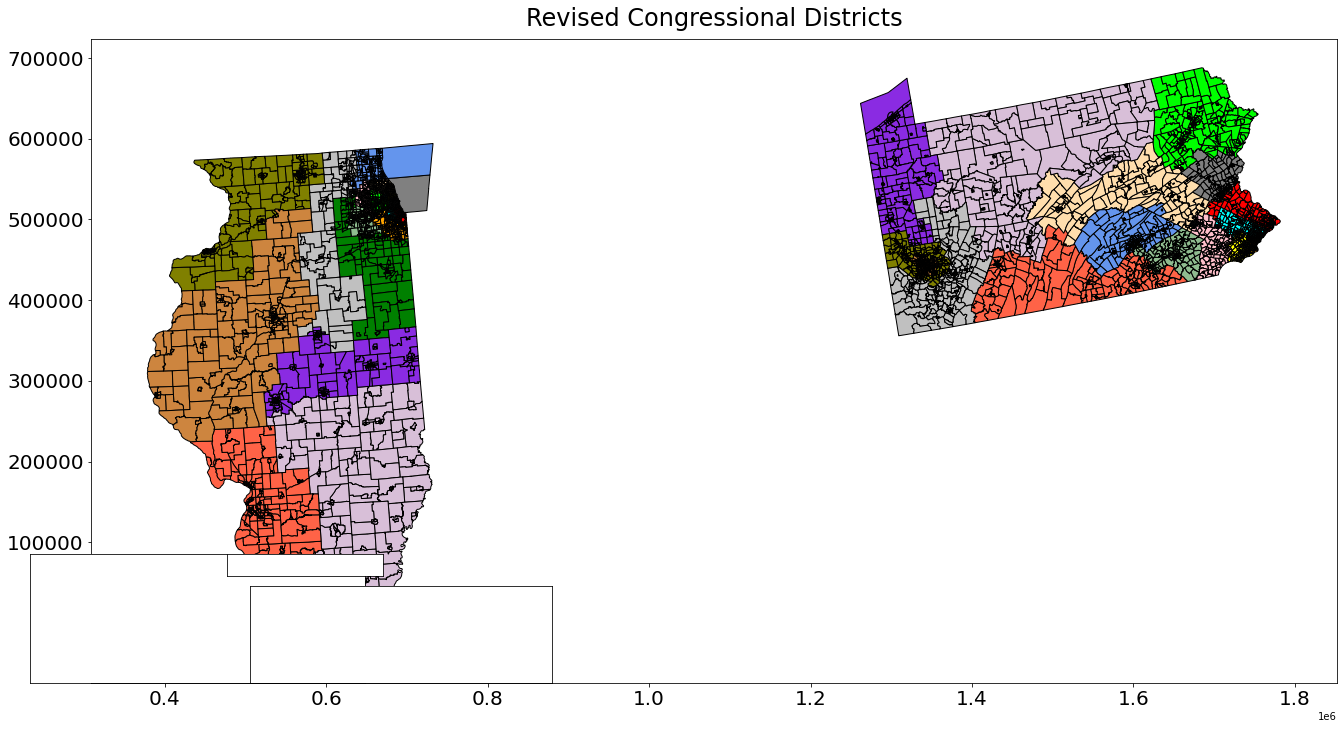

Done plotting and saving in 63 seconds!


In [19]:
s = time.time()
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "

alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = False

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    new_district_list = tract_gdf[(tract_gdf['STUSAB'] == this_state)]['new_district'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(new_district_list)+1):
        tract_gdf[
            (tract_gdf['STUSAB'] == this_state) 
            & (tract_gdf['new_district'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
    

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STUSAB'].apply(lambda x: x not in ['AK','HI'])].to_crs(main_map_crs).plot(ax=ax, color='blue', edgecolor='none', linewidth=0.5)



    
#ax.legend(handles=legend_list, fontsize=10)

ax.set_title('Revised Congressional Districts', fontsize=24, y=1.01)

ax.tick_params(axis='both', labelsize=20)

# # # # # # print('saving figure...')
# # # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # # #plt.show()
# # # e = time.time()
# # # g += (e-s)
# # # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'AK')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(new_district_list)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'HI')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'HI') & (tract_gdf['new_district'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

### Check RI
# ax.set_xlim([1.9e6, 2.2e6])
# ax.set_ylim([.7e6, .9e6])

for thisax in [ak_inset_ax, aleutians_inset_ax, hi_inset_ax]: #[ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

plt.show()
# print('saving figure...')
# fig.savefig(script_dir+'new-districts-11.jpg', format='jpg', dpi=300, bbox_inches='tight')
e = time.time()
g += (e-s)
print('Done plotting and saving in {0:,.0f} seconds!'.format(e-s))


In [20]:
s = time.time()
tract_gdf['new_district'].to_csv(script_dir+'new-districts-17.csv')
e = time.time()
g += (e-s)
print('Classified and saved {0:,.0f} in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf), np.floor((e-s)/60), (e-s)%60))
print('\n')
print('TOTAL TIME: {0:,.0f} minutes {1:,.0f} seconds!'.format( np.floor(g/60), g%60))

Classified and saved 6,711 in 0 minutes 0 seconds!


TOTAL TIME: 6 minutes 48 seconds!


# PENNSYLVANIA

In [21]:
# s = time.time()

# this_state = 'PA'
# examine_duplicates = True

# nDistricts = these_states_dict[this_state]['seats_new']
# state_target = these_states_dict[this_state]['target']

# #print('getting from backup...')
# tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

# county_mapper_df = pandas.DataFrame(data=[ 

# ['Delaware County',5], 

# ['Bucks County',1],
    
# ['Beaver County',16],
    
# ['Carbon County',7],

# ['Cumberland County',10],
#     ['Dauphin County',10],
#     ['Perry County',10],
#     ['Lebanon County',10],
#     ['Juniata County',10],
    
# ['Lackawanna County',8],
#     ['Wayne County',8],
#     ['Pike County',8],
#     ['Wyoming County',8],
#     ['Susquehanna County',8],
    
# ['Lancaster County',11],
    
# ['Erie County',15],
#     ['Crawford County',15],
#     ['Mercer County',15],
#     ['Lawrence County',15],
#     ['Venango County',15],
        
# ['Adams County',13],
#     ['Franklin County',13],
#     ['Fulton County',13],
#     ['Bedford County',13],
#     ['Somerset County',13],
    
# ['Washington County',14],
#     ['Greene County',14],
#     ['Fayette County',14],
#     ['Armstrong County',14],
    
# ['Mifflin County',9],
#     ['Snyder County',9],
#     ['Northumberland County',9],
#     ['Union County',9],
#     ['Centre County',9],
#     ['Columbia County',9],
#     ['Montour County',9],
    
# ], columns=['COUNTY_NAME', 'new_district_by_county'])
# county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

# place_mapper_df = pandas.DataFrame(data=[
    
# ['Reading',6], 
#     ['West Reading',6], 
#     ['Wyomissing',6],


# ['Pittsburgh',17],
#     ['Mount Oliver',17], 
#     ['Homestead',17], 
#     ['West Homestead',17], 
#     ['Green Tree',17], 
#     ['Ingram',17], 
#     ['Thornburg',17], 
#     ['Rosslyn Farms',17], 
#     ['Carnegie',17], 
#     ['Dormont',17], 
#     ['Castle Shannon',17], 
#     ['Brentwood',17], 
#     ['Whitehall',17],
#     ['Whitaker',17], 
#     ['Rankin',17], 
#     ['Swissvale',17], 
#     ['Edgewood',17], 
#     ['Wilkinsburg',17], 
#     ['Braddock Hills',17], 
#     ['Forest Hills',17], 
#     ['Munhall',17], 
#     ['Baldwin',17], 
#     ['Crafton',17], 
#     ['Braddock',17], 
#     ['Churchill',17], 
#     ['McKees Rocks',17],
#     ['Glassport',17], 
#     ['Liberty',17], 
#     ['Port Vue',17], 
#     ['Dravosburg',17], 
#     ['McKeesport',17], 
#     ['Boston',17], 
#     ['North Braddock',17],
#     ['East Pittsburgh',17], 
#     ['Etna',17], 
#     ['Aspinwall',17], 
#     ['Millvale',17], 
#     ['Duquesne',17], 
#     ['West View',17],
#     ['Avalon',17],
#     ['Bellevue',17],
#     ['Glenshaw',17],
    

# ['New Kensington',16], 
#     ['Arnold',16], 
#     ['Lower Burrell',16], 
#     ['Murrysville',16], 
#     ['Export',16], 
#     ['Delmont',16], 
#     ['Irwin',16], 
#     ['Manor',16], 
#     ['Harrison City',16], 

    
# ['Stroudsburg',7], 
#     ['East Stroudsburg',7], 
#     ['Arlington Heights',7], 
#     ['Sierra View',7], 
#     ['Sun Valley',7], 
#     ['Effort',7], 
    
    
# ['Wilkes-Barre',8], 
#     ['Kingston',8], 
#     ['Edwardsville',8], 
#     ['Pringle',8], 
#     ['Courtdale',8], 
#     ['Luzerne',8], 
#     ['Larksville',8],  
#     ['Laurel Run',8], 
#     ['Ashley',8], 
#     ['Plymouth',8], 
#     ['Chase',8],
#     ['Mountain Top',8], 
#     ['Sugar Notch',8], 
#     ['Warrior Run',8],
#     ['Nanticoke',8],
#     ['West Nanticoke',8],
#     ['Sheatown',8],
#     ['Conyngham',8],
    
    
# ['York',11], 
#     ['North York',11], 
#     ['West York',11], 
#     ['Grantley',11], 
#     ['East York',11], 
#     ['Stonybrook',11], 
#     ['Yorklyn',11], 
#     ['Queens Gate',11],
#     ['Tyler Run',11], 
#     ['Dallastown',11], 
#     ['Yoe',11], 
#     ['Red Lion',11],
    

    
# ['Butler',15], 
#     ['Oak Hills',15], 
#     ['Homeacre-Lyndora',15], 
#     ['Shanor-Northvue',15], 
#     ['Meadowood',15],
    
    
# ['Indiana',14],
#     ['Chevy Chase Heights',14],
    
    
# ['Johnstown',13],
    
# ], columns=['NAME', 'new_district_by_place'])


# #print('Assigning districts by county...')
# tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']

# print('Assigning districts by place...')
# place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf[place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]].reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


# print('Accounting for known duplicate places...')
# keepers = {}
# keepers['Eagleville'] = {'GEOID': '1600000US4220672', 'description': 'overlaps 1 tracts containing 5,626 people'}
# keepers['Edgewood'] = {'GEOID': '1600000US4222520', 'description': 'overlaps 2 tracts containing 3,145 people'}
# keepers['Liberty'] = {'GEOID': '1600000US4243064', 'description': 'overlaps 1 tracts containing 2,355 people'}

# for k,v in keepers.items():
#     print('\t{0:}: Keeping GEOID = {1:}: {2:}!'.format(k, v['GEOID'], v['description']))
#     place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == k) & (place_mapper_gdf.index != v['GEOID'])].index, axis=0)

# print('\n')
# print('checking for additional duplicate names...')
# duplicate_place_names = place_mapper_gdf[place_mapper_gdf['NAME'].duplicated()]['NAME'].tolist()
# for this_place in duplicate_place_names:
#     print('Examining {0:}...'.format(this_place))
    
#     for ix, thisrow in place_gdf[
#         (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#         & (place_gdf['NAME'] == this_place)
#     ].to_crs(equal_area_crs).iterrows():
#         included_tracts = []
#         place_area = thisrow.geometry.area
#         print('\t{0:} (GEOID = {1:}), place area = {2:,.2f} km^2...'.format(thisrow['NAMELSAD'], ix, place_area / 1000000))
        
#         for jx, thatrow in county_gdf[
#             (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#             & (county_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
#         ].to_crs(equal_area_crs).iterrows():
#             if (thatrow.geometry.intersection(thisrow.geometry).area >= absolute_overlap_tol):
#                 print('\t\t...overlaps with {0:} by {1:,.2f} km^2...'.format(thatrow['NAMELSAD'], thatrow.geometry.intersection(thisrow.geometry).area / 1000000))
#                 for kx, otherrow in tract_gdf[
#                     #(tract_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#                     (tract_gdf['STUSAB'] == this_state)
#                     & (tract_gdf['COUNTY_NAME'] == thatrow['NAMELSAD'])
#                     & (tract_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
#                 ].to_crs(equal_area_crs).iterrows():
#                     tract_area = otherrow.geometry.area
#                     overlap_area = otherrow.geometry.intersection(thisrow.geometry).area
#                     pct_overlap = overlap_area / tract_area
#                     if (pct_overlap >= desired_pct_area_overlap):
#                         print('\t\t\tOverlaps {0:.1%} of census tract {1:}...'.format(pct_overlap, otherrow['census_tract']))
#                         included_tracts.append(kx)
#         print('\t{0:} (GEOID = {1:}) overlaps {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAME'], ix, len(tract_gdf[tract_gdf.index.isin(included_tracts)]), tract_gdf[tract_gdf.index.isin(included_tracts)]['POP100'].sum()))
#         print('-------------------------------------')
#         print('\n')
        
# print('\n')
# for i in range(1, nDistricts+1):
#     print('Looking for tracts related to places in District {0:.0f}...'.format(i))
#     tracts_here = []
#     this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
#     tracts_within = tract_gdf[
#         (tract_gdf['STUSAB'] == this_state) 
#         & (tract_gdf['new_district'].isnull()) 
#         & (tract_gdf.geometry.within(this_district_places_geo))
#     ].index.tolist()
#     if (len(tracts_within) > 0):
#         print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
#     tracts_here += tracts_within
    
#     intersecting_tracts = tract_gdf[
#         (tract_gdf['STUSAB'] == this_state) 
#         & (tract_gdf['new_district'].isnull()) 
#         & (tract_gdf.geometry.intersects(this_district_places_geo))
#         & ~(tract_gdf.index.isin(tracts_within))
#     ].index.tolist()
#     if (len(intersecting_tracts) > 0):
#         print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
#     cnt = 0
#     for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
#         cnt += 1
#         if (np.mod(cnt,50) == 1):            
#             print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
#         tract_area_sq_deg = thisrow.geometry.area
#         overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
#         overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
#         if (overlap_pct >= desired_pct_area_overlap):
#             tracts_here.append(ix)
#             #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

#     tract_gdf.loc[tracts_here, 'new_district'] = i

# print('Assigning districts by tract number...')
# tract_gdf.loc[['1400000US42101000101', '1400000US42101000102', '1400000US42101000200', '1400000US42101000300', '1400000US42101000401', '1400000US42101000403', '1400000US42101000404', '1400000US42101000500', '1400000US42101000600', '1400000US42101000701', '1400000US42101000702', '1400000US42101000801', '1400000US42101000803', '1400000US42101000805', '1400000US42101000806', '1400000US42101000901', '1400000US42101000902'], 'new_district'] = 3
# tract_gdf.loc[['1400000US42101001001', '1400000US42101001002', '1400000US42101001101', '1400000US42101001102', '1400000US42101001201', '1400000US42101001203', '1400000US42101001204', '1400000US42101001301', '1400000US42101001302', '1400000US42101001400', '1400000US42101001500', '1400000US42101001600', '1400000US42101001700', '1400000US42101001800', '1400000US42101001900'], 'new_district'] = 3
# tract_gdf.loc[['1400000US42101002000', '1400000US42101002100', '1400000US42101002200', '1400000US42101002300', '1400000US42101002400', '1400000US42101002500', '1400000US42101002701', '1400000US42101002702', '1400000US42101002801', '1400000US42101002802', '1400000US42101002900', '1400000US42101003001', '1400000US42101003002', '1400000US42101003100', '1400000US42101003200', '1400000US42101003300', '1400000US42101003600', '1400000US42101003701', '1400000US42101003702', '1400000US42101003800', '1400000US42101003901', '1400000US42101003902'], 'new_district'] = 3
# tract_gdf.loc[['1400000US42101004001', '1400000US42101004002', '1400000US42101004101', '1400000US42101004103', '1400000US42101004104', '1400000US42101004201', '1400000US42101004202', '1400000US42101005400', '1400000US42101005500', '1400000US42101005600', '1400000US42101006000', '1400000US42101006100', '1400000US42101006200', '1400000US42101006300', '1400000US42101006400', '1400000US42101006500', '1400000US42101006600', '1400000US42101006700', '1400000US42101007000', '1400000US42101007101', '1400000US42101007102', '1400000US42101007200', '1400000US42101007300', '1400000US42101007400', '1400000US42101007700', '1400000US42101007800', '1400000US42101007900'], 'new_district'] = 3
# tract_gdf.loc[['1400000US42101008000', '1400000US42101008101', '1400000US42101008102', '1400000US42101008200', '1400000US42101008301', '1400000US42101008302', '1400000US42101008400', '1400000US42101008500', '1400000US42101008601', '1400000US42101008602', '1400000US42101008701', '1400000US42101008702', '1400000US42101008801', '1400000US42101008802', '1400000US42101009000', '1400000US42101009100', '1400000US42101009200', '1400000US42101009300', '1400000US42101009400', '1400000US42101009500', '1400000US42101009600'], 'new_district'] = 3
# tract_gdf.loc[['1400000US42101010000', '1400000US42101010100', '1400000US42101010200', '1400000US42101010300', '1400000US42101010400', '1400000US42101010500', '1400000US42101010600', '1400000US42101010700', '1400000US42101010800', '1400000US42101010900', '1400000US42101011000', '1400000US42101011100', '1400000US42101011200', '1400000US42101011300', '1400000US42101011400', '1400000US42101011800', '1400000US42101012501', '1400000US42101012502'], 'new_district'] = 3
# tract_gdf.loc[['1400000US42101013200', '1400000US42101013300', '1400000US42101013401', '1400000US42101013402', '1400000US42101013500', '1400000US42101013601', '1400000US42101014202', '1400000US42101036600', '1400000US42101036700', '1400000US42101036901', '1400000US42101036902', '1400000US42101037200', '1400000US42101037300', '1400000US42101037600', '1400000US42101039100'], 'new_district'] = 3
# tract_gdf.loc[['1400000US42101980001', '1400000US42101980002', '1400000US42101980003', '1400000US42101980400', '1400000US42101980600', '1400000US42101980701', '1400000US42101980702', '1400000US42101980800', '1400000US42101980901', '1400000US42101980902', '1400000US42101980903', '1400000US42101980904', '1400000US42101980905', '1400000US42101980906', '1400000US42101989200','1400000US42101011700', '1400000US42101011900', '1400000US42101012000', '1400000US42101012100', '1400000US42101012201', '1400000US42101012203', '1400000US42101012204', '1400000US42101013602', '1400000US42101013701', '1400000US42101013702','1400000US42101013800', '1400000US42101013900'], 'new_district'] = 3
# tract_gdf.loc[['1400000US42101014000', '1400000US42101014100', '1400000US42101014201', '1400000US42101014300', '1400000US42101014400', '1400000US42101014500', '1400000US42101014600', '1400000US42101014700', '1400000US42101014800', '1400000US42101014900', '1400000US42101015101', '1400000US42101015102', '1400000US42101015200', '1400000US42101015300', '1400000US42101015600', '1400000US42101015700', '1400000US42101015800'], 'new_district'] = 3
# tract_gdf.loc[['1400000US42101016001', '1400000US42101016002', '1400000US42101016100', '1400000US42101016200', '1400000US42101016300', '1400000US42101016400', '1400000US42101016500', '1400000US42101016600', '1400000US42101016701', '1400000US42101016702', '1400000US42101016800', '1400000US42101016901', '1400000US42101016902', '1400000US42101017100', '1400000US42101017201', '1400000US42101017202', '1400000US42101017300', '1400000US42101017400', '1400000US42101017500', '1400000US42101017601', '1400000US42101017602', '1400000US42101017701', '1400000US42101017702', '1400000US42101017800', '1400000US42101017900', '1400000US42101019501', '1400000US42101019502'], 'new_district'] = 3
# tract_gdf.loc[['1400000US42101013100', '1400000US42101009801', '1400000US42101009802', '1400000US42101011500', '1400000US42101037500', '1400000US42101037700'], 'new_district'] = 3     # Some tracts missed in Philadelphia


# tract_gdf.loc[['1400000US42101017000', '1400000US42101018001', '1400000US42101018002','1400000US42101018300', '1400000US42101018400', '1400000US42101018801', '1400000US42101018802', '1400000US42101019000', '1400000US42101019100', '1400000US42101019200', '1400000US42101019700', '1400000US42101019800', '1400000US42101019900'], 'new_district'] = 2
# tract_gdf.loc[['1400000US42101020000', '1400000US42101020101', '1400000US42101020102', '1400000US42101020200', '1400000US42101020300', '1400000US42101020400', '1400000US42101020500', '1400000US42101020600', '1400000US42101020701', '1400000US42101020702', '1400000US42101020800', '1400000US42101020900', '1400000US42101021000', '1400000US42101021100', '1400000US42101021200', '1400000US42101021300', '1400000US42101021400', '1400000US42101021500', '1400000US42101024000', '1400000US42101024200', '1400000US42101024300', '1400000US42101024400', '1400000US42101024500'], 'new_district'] = 2
# tract_gdf.loc[['1400000US42101028000', '1400000US42101028300', '1400000US42101028400', '1400000US42101028700', '1400000US42101028800', '1400000US42101028901', '1400000US42101029300', '1400000US42101029400', '1400000US42101029900', '1400000US42101037800', '1400000US42101037900', '1400000US42101038000', '1400000US42101038100', '1400000US42101038200', '1400000US42101038301', '1400000US42101980100', '1400000US42101980500', '1400000US42101989300'], 'new_district'] = 2
# tract_gdf.loc[['1400000US42101021600', '1400000US42101021700', '1400000US42101021800', '1400000US42101021900', '1400000US42101022000', '1400000US42101023100', '1400000US42101023500', '1400000US42101023600', '1400000US42101023700', '1400000US42101023800', '1400000US42101023900', '1400000US42101024100', '1400000US42101024600', '1400000US42101024700', '1400000US42101024800', '1400000US42101024900'], 'new_district'] = 2
# tract_gdf.loc[['1400000US42101025200', '1400000US42101025300', '1400000US42101025400', '1400000US42101025500', '1400000US42101025600', '1400000US42101025700', '1400000US42101025800', '1400000US42101025900', '1400000US42101026000', '1400000US42101026100', '1400000US42101026200', '1400000US42101026301', '1400000US42101026302', '1400000US42101026400', '1400000US42101026500', '1400000US42101026600', '1400000US42101026700', '1400000US42101026800', '1400000US42101026900'], 'new_district'] = 2
# tract_gdf.loc[['1400000US42101027000', '1400000US42101027100', '1400000US42101027200', '1400000US42101027300', '1400000US42101027401', '1400000US42101027402', '1400000US42101027500', '1400000US42101027600', '1400000US42101027700', '1400000US42101027800', '1400000US42101027901', '1400000US42101027902', '1400000US42101028100', '1400000US42101028200', '1400000US42101028500', '1400000US42101028600', '1400000US42101028902', '1400000US42101029000', '1400000US42101029100', '1400000US42101029200', '1400000US42101029800'], 'new_district'] = 2
# tract_gdf.loc[['1400000US42101030000', '1400000US42101030100', '1400000US42101030200', '1400000US42101030501', '1400000US42101030502', '1400000US42101030600', '1400000US42101030700', '1400000US42101030800', '1400000US42101030900', '1400000US42101031000', '1400000US42101031101', '1400000US42101031102', '1400000US42101031200', '1400000US42101031300', '1400000US42101031401', '1400000US42101031402', '1400000US42101031501', '1400000US42101031502'], 'new_district'] = 2
# tract_gdf.loc[['1400000US42101031600', '1400000US42101031700', '1400000US42101031800','1400000US42101031900', '1400000US42101032000', '1400000US42101032100', '1400000US42101032300', '1400000US42101032500', '1400000US42101032600', '1400000US42101032900', '1400000US42101033000', '1400000US42101033101', '1400000US42101033102', '1400000US42101033200', '1400000US42101033300', '1400000US42101033400', '1400000US42101033500', '1400000US42101033600', '1400000US42101033701', '1400000US42101033702', '1400000US42101033800', '1400000US42101033900'], 'new_district'] = 2
# tract_gdf.loc[['1400000US42101034000', '1400000US42101034100', '1400000US42101034200', '1400000US42101034400', '1400000US42101034501', '1400000US42101034502', '1400000US42101034600', '1400000US42101034701', '1400000US42101034702', '1400000US42101034801', '1400000US42101034802', '1400000US42101034803', '1400000US42101034900',    '1400000US42101035301', '1400000US42101035302', '1400000US42101035500', '1400000US42101035601', '1400000US42101038400', '1400000US42101038500', '1400000US42101038600', '1400000US42101038700', '1400000US42101038800', '1400000US42101038900', '1400000US42101039001', '1400000US42101039002', '1400000US42101989100','1400000US42101035100', '1400000US42101035200', '1400000US42101980200'], 'new_district'] = 2


# tract_gdf.loc[['1400000US42029300101', '1400000US42029300104', '1400000US42029300108', '1400000US42029300109', '1400000US42029300201', '1400000US42029300202', '1400000US42029300301', '1400000US42029300302', '1400000US42091203105', '1400000US42091203106'], 'new_district'] = 5     # NE Chester / SE Montgomery County
# tract_gdf.loc[['1400000US42091204002', '1400000US42091204007', '1400000US42091204008', '1400000US42091204101', '1400000US42091204103', '1400000US42091204104', '1400000US42091204200', '1400000US42091204500', '1400000US42091204600', '1400000US42091204701', '1400000US42091204702', '1400000US42091204800', '1400000US42091204900'], 'new_district'] = 5     # NE Chester / SE Montgomery County
# tract_gdf.loc[['1400000US42091205000', '1400000US42091205100', '1400000US42091205200', '1400000US42091205300', '1400000US42091205401', '1400000US42091205402', '1400000US42091205501', '1400000US42091205502', '1400000US42091205503', '1400000US42091205600', '1400000US42091205700', '1400000US42091205805', '1400000US42091205806'], 'new_district'] = 5     # NE Chester / SE Montgomery County
# tract_gdf.loc[['1400000US42091205807', '1400000US42091205808', '1400000US42091205809', '1400000US42091205810', '1400000US42091205811', '1400000US42091205903', '1400000US42091205904', '1400000US42091205905', '1400000US42091205906', '1400000US42091980300', '1400000US42029300103', '1400000US42029300303', '1400000US42029300400', '1400000US42091204300', '1400000US42091204400', '1400000US42091203902'], 'new_district'] = 5     # NE Chester / SE Montgomery County


# tract_gdf.loc[['1400000US42101035602', '1400000US42101035701', '1400000US42101035702', '1400000US42101035800', '1400000US42101035900', '1400000US42101036000', '1400000US42101036100', '1400000US42101036400'], 'new_district'] = 4      # Philadelphia
# tract_gdf.loc[['1400000US42101036501', '1400000US42101036502', '1400000US42101980300', '1400000US42101036302'], 'new_district'] = 4   


# # Rest of Montgomery County is District 4
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == 'Montgomery County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 4


# tract_gdf.loc[['1400000US42101036201', '1400000US42101036202', '1400000US42101036203', '1400000US42101036301', '1400000US42101036303'], 'new_district'] = 1    # Far NE Philadelphia
# tract_gdf.loc[['1400000US42077006402', '1400000US42077006902', '1400000US42077006903', '1400000US42077006905', '1400000US42077006906', '1400000US42077007000', '1400000US42077006702'], 'new_district'] = 1    # SE Lehigh County
# tract_gdf.loc[['1400000US42095017902', '1400000US42095018001', '1400000US42095018003', '1400000US42095018004', '1400000US42095018100', '1400000US42095017901'], 'new_district'] = 1    # S Northampton County
# tract_gdf.loc[['1400000US42077006302'], 'new_district'] = 1    # S Lehigh County
# tract_gdf.loc[['1400000US42011013100', '1400000US42011013200', '1400000US42011013301', '1400000US42011013302'], 'new_district'] = 1    # NE Berks County
# tract_gdf.loc[['1400000US42011013402', '1400000US42011014201', '1400000US42011014202'], 'new_district'] = 1    # NE Berks County
        

# # Rest of Chester County is District 6
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == 'Chester County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 6

# tract_gdf.loc[['1400000US42011011703', '1400000US42011011704', '1400000US42011011705', '1400000US42011011902', '1400000US42011011903', '1400000US42011011905', '1400000US42011011906'], 'new_district'] = 6    # E Berks County
# tract_gdf.loc[['1400000US42011011702', '1400000US42011012902', '1400000US42011013000'], 'new_district'] = 6    # E Berks County
# tract_gdf.loc[['1400000US42011011300', '1400000US42011011400', '1400000US42011011500', '1400000US42011011601', '1400000US42011011602', '1400000US42011011603', '1400000US42011011800', '1400000US42011012001', '1400000US42011012003', '1400000US42011012004'], 'new_district'] = 6     # S and E of Reading
# tract_gdf.loc[['1400000US42011012001', '1400000US42011012003', '1400000US42011012004', '1400000US42011012101', '1400000US42011012103', '1400000US42011012104', '1400000US42011012106', '1400000US42011012107', '1400000US42011012200', '1400000US42011012300'], 'new_district'] = 6     # S and E of Reading
# tract_gdf.loc[['1400000US42011010803', '1400000US42011010902', '1400000US42011010903', '1400000US42011010904', '1400000US42011010905'], 'new_district'] = 6     # W of Reading
# tract_gdf.loc[['1400000US42011012400', '1400000US42011012500', '1400000US42011012600', '1400000US42011012701', '1400000US42011012702', '1400000US42011012800', '1400000US42011012901'], 'new_district'] = 6     # NW of Reading


# tract_gdf.loc[['1400000US42003488100', '1400000US42003488200', '1400000US42003488300', '1400000US42003488400', '1400000US42003488500', '1400000US42003488600'], 'new_district'] = 17     # Between Jefferson Hills and Homestead
# tract_gdf.loc[['1400000US42003470300', '1400000US42003470501', '1400000US42003470502', '1400000US42003470600'], 'new_district'] = 17     # S of Green Tree
# tract_gdf.loc[['1400000US42003473100', '1400000US42003473200', '1400000US42003473300', '1400000US42003473401', '1400000US42003473402', '1400000US42003473500', '1400000US42003473601', '1400000US42003473602'], 'new_district'] = 17     # E of Heidelberg
# tract_gdf.loc[['1400000US42003479000', '1400000US42003471000'], 'new_district'] = 17     # N of Castle Shannon
# tract_gdf.loc[['1400000US42003489001', '1400000US42003489002'], 'new_district'] = 17     # SE of Whitehall
# tract_gdf.loc[['1400000US42003427100', '1400000US42003427200', '1400000US42003428100', '1400000US42003428200'], 'new_district'] = 17     # Millvale area
# tract_gdf.loc[['1400000US42003429100', '1400000US42003429201', '1400000US42003429202', '1400000US42003429300', '1400000US42003429400', '1400000US42003429500', '1400000US42003429600', '1400000US42003429700'], 'new_district'] = 17     # West View area
# tract_gdf.loc[['1400000US42003460001', '1400000US42003460002', '1400000US42003462100', '1400000US42003462600', '1400000US42003434000', '1400000US42003435000'], 'new_district'] = 17     # Neville Island area
# tract_gdf.loc[['1400000US42003421200', '1400000US42003424000', '1400000US42003426700'], 'new_district'] = 17     # Aspinwall area
# tract_gdf.loc[['1400000US42003504100', '1400000US42003509400', '1400000US42003520001', '1400000US42003520002'], 'new_district'] = 17     # E of East Pittsburgh
# tract_gdf.loc[['1400000US42003523100', '1400000US42003523200', '1400000US42003523300', '1400000US42003523400', '1400000US42003523501', '1400000US42003523502', '1400000US42003523600', '1400000US42003523701', '1400000US42003523702', '1400000US42003523800'], 'new_district'] = 17     # N of Wilkinsburg
# tract_gdf.loc[['1400000US42003461000', '1400000US42003437000', '1400000US42003563800'], 'new_district'] = 17     # Ohio River west of Pittsburgh


# # # Rest of Allegheny County is District 16
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == 'Allegheny County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 16

# tract_gdf.loc[['1400000US42129801701'], 'new_district'] = 16     # NE of Plum
# tract_gdf.loc[['1400000US42129802200', '1400000US42129802301', '1400000US42129802303', '1400000US42129802304'], 'new_district'] = 16     # Level Green area
# tract_gdf.loc[['1400000US42129803100', '1400000US42129803200', '1400000US42129803301', '1400000US42129803302', '1400000US42129803400', '1400000US42129803502'], 'new_district'] = 16     # Between White Oak and Irwin
        

# # # Rest of Lehigh and NorthamptonCounties are District 7
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'].isin(['Lehigh County', 'Northampton County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 7
        
# tract_gdf.loc[['1400000US42089301002', '1400000US42089301005', '1400000US42089301101', '1400000US42089301102', '1400000US42089301202', '1400000US42089301203', '1400000US42089301207', '1400000US42089301302', '1400000US42089301303', '1400000US42089301304'], 'new_district'] = 7    # S Monroe County
# tract_gdf.loc[['1400000US42089300406', '1400000US42089300407'], 'new_district'] = 7    # S Monroe County


# tract_gdf.loc[['1400000US42107003900', '1400000US42107003700'], 'new_district'] = 10    # Far S Schuylkill County


# ### Rest of Monroe County is District 8
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == 'Monroe County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 8

# tract_gdf.loc[['1400000US42079210100', '1400000US42079210200', '1400000US42079210300', '1400000US42079210400', '1400000US42079210500', '1400000US42079210600', '1400000US42079210700', '1400000US42079210800', '1400000US42079211000', '1400000US42079211101', '1400000US42079211102', '1400000US42079211201', '1400000US42079211203', '1400000US42079211204', '1400000US42079211205', '1400000US42079211301', '1400000US42079211302', '1400000US42079211303'], 'new_district'] = 8      # NE Luzerne County
# tract_gdf.loc[['1400000US42079211400', '1400000US42079211500', '1400000US42079211600', '1400000US42079211701', '1400000US42079211702', '1400000US42079211800', '1400000US42079211900', '1400000US42079212000', '1400000US42079212100', '1400000US42079212200', '1400000US42079213900', '1400000US42079214500', '1400000US42079214600', '1400000US42079214900', '1400000US42079215200', '1400000US42079215300', '1400000US42079215400', '1400000US42079215501', '1400000US42079215503', '1400000US42079215504', '1400000US42079215600', '1400000US42079215701', '1400000US42079216200', '1400000US42079216602', '1400000US42079216800', '1400000US42079218000'], 'new_district'] = 8      # NE Luzerne County
# tract_gdf.loc[['1400000US42079211304', '1400000US42079215702', '1400000US42079215800', '1400000US42079215900'], 'new_district'] = 8     # NW Luzerne County
# tract_gdf.loc[['1400000US42079216100', '1400000US42079216601', '1400000US42079216700', '1400000US42079216900', '1400000US42079216502'], 'new_district'] = 8     # S Luzerne County

        
# tract_gdf.loc[['1400000US42133010120', '1400000US42133010132', '1400000US42133010300', '1400000US42133010400', '1400000US42133010520'], 'new_district'] = 11     # York area
# tract_gdf.loc[['1400000US42133022801', '1400000US42133022802', '1400000US42133022920', '1400000US42133022921', '1400000US42133022922', '1400000US42133022923', '1400000US42133023301', '1400000US42133023302'], 'new_district'] = 11     # SE of York
# tract_gdf.loc[['1400000US42133023400', '1400000US42133023500', '1400000US42133023601', '1400000US42133023602'], 'new_district'] = 11     # NE of York
# tract_gdf.loc[['1400000US42133020802', '1400000US42133020910', '1400000US42133020921', '1400000US42133020922', '1400000US42133021010', '1400000US42133021020'], 'new_district'] = 11     # NW of York
# tract_gdf.loc[['1400000US42133020100', '1400000US42133020220', '1400000US42133020221', '1400000US42133020222'], 'new_district'] = 11     # S of Harrisburg


# tract_gdf.loc[['1400000US42019912001', '1400000US42019912002', '1400000US42019912101', '1400000US42019912102', '1400000US42019912200', '1400000US42019912301', '1400000US42019912303', '1400000US42019912304', '1400000US42019912404', '1400000US42019912405', '1400000US42019912406', '1400000US42019912403'], 'new_district'] = 15     # SW Butler County
# tract_gdf.loc[['1400000US42019911100', '1400000US42019911700', '1400000US42019911800', '1400000US42019911900'], 'new_district'] = 15     # Central-west Butler County
# tract_gdf.loc[['1400000US42019910301', '1400000US42019910302', '1400000US42019911000', '1400000US42019980100', '1400000US42019910400'], 'new_district'] = 15     # NW Butler County
# tract_gdf.loc[['1400000US42019903000', '1400000US42019910800'], 'new_district'] = 15     # Unionville area
# tract_gdf.loc[['1400000US42019911600', '1400000US42019911200'], 'new_district'] = 15     # Central Butler County
# tract_gdf.loc[['1400000US42019911501', '1400000US42019911502', '1400000US42019912800'], 'new_district'] = 15     # NW Butler County


# ### Rest of Berks, Schuylkill, Luzerne County is District 9
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'].isin(['Berks County', 'Schuylkill County', 'Luzerne County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 9

# tract_gdf.loc[['1400000US42061950100', '1400000US42061950200'], 'new_district'] = 9     # N Huntingdon County


# ### Rest of Westmoreland and Butler County is District 14
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'].isin(['Westmoreland County', 'Butler County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 14

# tract_gdf.loc[['1400000US42063961600', '1400000US42063961700', '1400000US42063961800', '1400000US42063961900', '1400000US42063962000', '1400000US42063962100'], 'new_district'] = 14     # S Indiana County
# tract_gdf.loc[['1400000US42063960600', '1400000US42063960700', '1400000US42063960700', '1400000US42063961102', '1400000US42063960800'], 'new_district'] = 14     # Indiana city area


# ### Rest of York and Huntingdon County is District 13
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'].isin(['York County', 'Huntingdon County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 13

# tract_gdf.loc[['1400000US42021010801', '1400000US42021011000', '1400000US42021011100', '1400000US42021011200', '1400000US42021011300', '1400000US42021011400'], 'new_district'] = 13     # SW Cambria County
# tract_gdf.loc[['1400000US42021010100', '1400000US42021010200', '1400000US42021010300', '1400000US42021010500', '1400000US42021010600', '1400000US42021010700', '1400000US42021013300', '1400000US42021013700'], 'new_district'] = 13     # SW Cambria County
# tract_gdf.loc[['1400000US42021012900', '1400000US42021013000', '1400000US42021013100', '1400000US42021013200', '1400000US42021011500'], 'new_district'] = 13     # SW Cambria County
# tract_gdf.loc[['1400000US42013011600'], 'new_district'] = 13      # S Blair County


# print('All the rest are district 12...')
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 12

# print('\n')


# # print('saving outfile...')
# # tract_gdf['new_district'].to_csv(script_dir+'illinois-so-far.csv')

# nDone = 0
# total_difference = 0
# total_sum = 0
# for i in range(-1, these_states_dict[this_state]['seats_new']+1):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         nDone += 1
#         total_sum += tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()
#         total_difference += tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target
#         #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
#         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))
        
# e = time.time()
# g += (e-s)

# print('\n')
# print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')
# print('After {0:,.0f} districts, off by {1:,.0f} ({2:.1%})'.format(nDone, total_difference, total_difference/total_sum))
# print('Done!')


In [22]:
# s = time.time()

# this_state = 'PA'

# show_water = True

# label_tracts = False

# show_counties = True
# label_counties = False

# show_places = False
# label_places = False

# print_ready = False
# assign_to_district = 15

# the_label_size = 20
# the_annotation_size = 18
# the_annotation_size_big = 18
# the_line_width = .5
# the_line_width_medium = 4
# the_line_width_wide = 6
# the_legend_size = 18
# the_title_size = 28

# show_roads = False
# show_minor_roads = False
# label_roads = False

# bounds_counties = []

# ### PHILADELPHIA METRO AREA
# #bounds_counties = ['Philadelphia', 'Delaware', 'Bucks', 'Chester', 'Montgomery', 'Lehigh', 'Northampton', 'Berks']


# ### PITTSBURGH METRO AREA
# #bounds_counties = ['Allegheny', 'Westmoreland', 'Washington', 'Butler', 'Beaver', 'Armstrong', 'Fayette']

# ### HARRISBURG METRO AREA
# #bounds_counties = ['Cumberland', 'Dauphin', 'Perry']


# ### WBS METRO AREA
# #bounds_counties = ['Lackawanna', 'Luzerne', 'Wyoming']




# if (len(bounds_counties) > 0):
#     xlimits = [unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[3]]
# else:
#     xlimits = [unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[3]]




# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = [xlimits[0] - xbuffer, xlimits[1] + xbuffer] #cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = [ylimits[0] - ybuffer, ylimits[1] + ybuffer] 

# # print(xlimits)
# # print(ylimits)
# print('xspan = {0:,.2f} km'.format(xspan / 1000))
# print('yspan = {0:,.2f} km'.format(yspan / 1000))
# print('aspect_ratio  = {0:,.2f}:1'.format(aspect_ratio))
# print('\n')

# viewport_gdf = geopandas.GeoDataFrame(data=[[box(xlimits[0], ylimits[0], xlimits[1], ylimits[1])]], columns=['geometry'], crs=main_map_crs, geometry='geometry')

# # fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
# fig, ax = plt.subplots(1,1,figsize=(24, 24/aspect_ratio))
# ax.set_aspect('equal')


# print('plotting tracts...')
# # base layer
# legend_list = []
# for i in range(-1,these_states_dict[this_state]['seats_new']+1):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         print(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum())
#         tract_gdf[(tract_gdf['new_district'] == i)].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black', linewidth=the_line_width)#, alpha=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i], label='District {0:,.0f}'.format(i)))

# # tract_gdf[(tract_gdf['new_district'].isnull())
# #          ].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', lw=1) #linestyle=(0,(1,8)), lw=6)



# if (show_places):
#     print('plotting places...')
#     place_gdf.to_crs(main_map_crs).plot(ax=ax, edgecolor='purple', lw=the_line_width_medium, color='none')
#     #place_gdf[place_gdf['NAME'] == 'Philadelphia'].to_crs(main_map_crs).plot(ax=ax, edgecolor='purple', lw=the_line_width_wide, color='none')
    

# if (show_water):
#     print('plotting water areas...')
#     water_gdf.to_crs(main_map_crs).plot(ax=ax, color='blue')#, alpha=0.5)

# if (show_counties):
#     print('plotting state and county borders...')
#     if (len(bounds_counties) > 0):   
#         county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
#     else:
#         county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
#     state_gdf[state_gdf['STUSPS'] == this_state].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width, zorder=99)

# if (label_counties):
#     print('labeling counties...')
#     if (len(bounds_counties) > 0):
#         counties_to_label = bounds_counties
#     else:
#         counties_to_label = county_gdf[county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]]['NAME'].tolist()
#     for ix, thisrow in county_gdf[
#         (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#         & (county_gdf['NAME'].isin(counties_to_label))
# #         & ( 
# #             ((county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x) >= xlimits[0]) & (county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
# #             & ((county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y) >= xlimits[0]) & (county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y) <= xlimits[1]))
# #         )        
#     ].to_crs(main_map_crs).iterrows():
#         ax.annotate('{0:}'.format(thisrow['NAME'].replace(' ','\n')), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), color='black', backgroundcolor='white', ha='center', va='center',  fontsize=the_annotation_size_big)

# if (show_roads):    
#     print('plotting roads...')
#     roads_gdf[roads_gdf['RTTYP'] == 'I'].to_crs(main_map_crs).plot(ax=ax, color=road_label_format['I']['thecolor'], lw=3)
#     roads_gdf[roads_gdf['RTTYP'] == 'U'].to_crs(main_map_crs).plot(ax=ax, color=road_label_format['U']['thecolor'], lw=2)
#     roads_gdf[roads_gdf['RTTYP'] == 'S'].to_crs(main_map_crs).plot(ax=ax, color=road_label_format['S']['thecolor'], lw=1.5)
#     roads_gdf[roads_gdf['RTTYP'] == 'C'].to_crs(main_map_crs).plot(ax=ax, color=road_label_format['C']['thecolor'], lw=1)

#     if (show_minor_roads):
#         roads_gdf[roads_gdf['RTTYP'] == 'M'].to_crs(main_map_crs).plot(ax=ax, color=road_label_format['M']['thecolor'], lw=0.5)
#         roads_gdf[roads_gdf['RTTYP'] == 'O'].to_crs(main_map_crs).plot(ax=ax, color=road_label_format['O']['thecolor'], lw=0.5)
#         roads_gdf[roads_gdf['RTTYP'].isnull()].to_crs(main_map_crs).plot(ax=ax, color=road_label_format['x']['thecolor'], lw=0.25)

# if (label_roads):
#     print('labeling roads...')
#     for ix, thisrow in geopandas.overlay(
#         roads_gdf[roads_gdf['RTTYP'].isin(['I','U','S','C'])].reset_index().to_crs(main_map_crs), viewport_gdf, how='intersection'
#     ).set_index('LINEARID').iterrows():
#         annotator = parse_road_name(thisrow['FULLNAME'])#'{0:}'.format(thisrow['FULLNAME'])
#         #centerpoint = thisrow.geometry.coords[int(np.floor(len(thisrow.geometry.coords)/2))]
#         centerpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
#         ax.annotate(annotator, centerpoint, 
#                     color=road_label_format[thisrow['RTTYP']]['labelcolor'], backgroundcolor='white', ha='center', va='center',
#                     fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
        
# if (label_places):
#     print('\tlabeling places...')
#     for ix, thisrow in geopandas.overlay(
#         place_gdf.reset_index().to_crs(main_map_crs),
#         geopandas.GeoDataFrame(data=[[box(xlimits[0], ylimits[0], xlimits[1], ylimits[1])]], columns=['geometry'], crs=main_map_crs, geometry='geometry'),
#         how='intersection').sort_values(by='NAME', ascending=False).set_index('GEOID').iterrows():
#             if (thisrow['NAME']  not in []):
#                 annotator = thisrow['NAME'].replace(' ', '\n')
#                 centerpoint = thisrow.geometry.centroid.coords[0]
#                 ax.annotate(annotator, centerpoint, color='red', ha='center', va='center', fontsize=the_annotation_size, bbox=dict(facecolor='white', edgecolor='black', pad=4))

                
                
# if (label_tracts):
#     print('\tlabeling tracts...')
#     if (print_ready):
#         print('\n')
#         print("tract_gdf.loc[[")
#     for ix, thisrow in geopandas.overlay(
#         tract_gdf[
#             (tract_gdf['new_district'].isnull())
#             #(tract_gdf['new_district'].isin([15]))
#             #((tract_gdf['new_district'].isnull()) | (tract_gdf['new_district'].isin([9,13])))
#         ].reset_index().to_crs(main_map_crs),
#         geopandas.GeoDataFrame(data=[[box(xlimits[0], ylimits[0], xlimits[1], ylimits[1])]], columns=['geometry'], crs=main_map_crs, geometry='geometry'),
#         how='intersection').set_index('GEOID').iterrows():
#             if (print_ready):
#                 print("\t'{0:}', ".format(ix))
#             else:
#                 print('\t{0:}-{1:}: {2:}'.format(thisrow['COUNTY_NAME'][0:3], thisrow['census_tract'], ix))
#             annotator = '{0:}\n({1:,.0f})'.format(thisrow['census_tract'], thisrow['POP100'])
#             centerpoint = thisrow.geometry.centroid.coords[0]
#             ax.annotate(annotator, centerpoint, color='black', ha='center', va='center', fontsize=the_annotation_size, bbox=dict(facecolor='white', edgecolor='black', pad=4))
#     if (print_ready):
#         print("], 'new_district'] = {0:.0f}".format(assign_to_district))


# plt.xlim(xlimits)
# plt.ylim(ylimits)

# ax.tick_params(axis='both', labelsize=20, labelbottom=True, labeltop=True, labelleft=True, labelright=True)
# #ax.legend(handles=legend_list, fontsize=20, loc='lower left')

# print('\n')    
# for i in range(-1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         #if (np.abs(1-(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target)) > 0.01):
#         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))

# e = time.time()
# g += (e-s)

# print('Plotted in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))


# plt.show()


In [23]:

#roads_gdf.head(1).T
# 	NAME	POP100
# GEOID		
# 37980	Philadelphia-Camden-Wilmington, PA-NJ-DE-MD	4218131.0
# 38300	Pittsburgh, PA	2370930.0
# 10900	Allentown-Bethlehem-Easton, PA-NJ	752257.0
# 25420	Harrisburg-Carlisle, PA	591712.0
# 42540	Scranton--Wilkes-Barre, PA	567559.0
# 29540	Lancaster, PA	552984.0
# 49620	York-Hanover, PA	456438.0
# 39740	Reading, PA	428849.0
# 21500	Erie, PA	270876.0
# 20700	East Stroudsburg, PA	168327.0
# 44300	State College, PA	158172.0
# 16540	Chambersburg-Waynesboro, PA	155932.0
# 30140	Lebanon, PA	143257.0
# 39060	Pottsville, PA	143049.0
# 27780	Johnstown, PA	133472.0
# print('backing up roads...')
# roads_gdf_bk = roads_gdf


In [24]:
# for ix, thisrow in geopandas.overlay(
#     roads_gdf[roads_gdf['RTTYP'] == 'I'].reset_index().to_crs(main_map_crs), viewport_gdf, how='intersection'
# ).set_index('LINEARID').iterrows():
#     print(np.floor(len(thisrow.geometry.coords)/2)+1)
#     centerpoint = thisrow.geometry.coords[int(np.floor(len(thisrow.geometry.coords)/2))]
#     print('-------')
# #     annotator = parse_road_name(thisrow['FULLNAME'])#'{0:}'.format(thisrow['FULLNAME'])
# #     centerpoint = thisrow.geometry.centroid.coords[0]
#     #ax.annotate(annotator, centerpoint, 
# #                 color='white', backgroundcolor='white', ha='center', va='center',
# #                 fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])




# s = time.time()

# this_state = 'IL'
# examine_duplicates = True

# nDistricts = these_states_dict[this_state]['seats_new']
# state_target = these_states_dict[this_state]['target']

# print('reading from file...')
# tract_gdf.loc[:, 'new_district'] = np.nan


# df = pandas.read_csv(script_dir+'illinois-so-far.csv', index_col='GEOID')
# tract_gdf.loc[df.index, 'new_district'] = df['new_district']
# tract_gdf.groupby('new_district')['POP100'].sum()


# county_mapper_df = pandas.DataFrame(data=[ 
    


# ], columns=['COUNTY_NAME', 'new_district_by_county'])
# county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

# place_mapper_df = pandas.DataFrame(data=[


# ], columns=['NAME', 'new_district_by_place'])

# print('Assigning districts by county...')
# for ix, thisrow in county_mapper_df.iterrows():
#     tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == thisrow['COUNTY_NAME']), 'new_district'] = thisrow['new_district_by_county']
# # #tract_gdf.loc[(tract_gdf[tract_gdf['STUSAB'] == this_state].index) & (tract_gdf['new_district'].isnull()), 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']

# print('Assigning districts by place...')
# place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


# print('Accounting for known duplicate places...')
# keepers = {}
# #keepers['Geneva'] = {'GEOID': '1600000US1728872', 'description': 'overlaps 4 tracts containing 19,896 people'}
# #keepers['Elgin'] = {'GEOID': '1600000US1723074', 'description': 'overlaps 21 tracts containing 107,141 people'}

# for k,v in keepers.items():
#     print('\t{0:}: Keeping GEOID = {1:}: {2:}!'.format(k, v['GEOID'], v['description']))
#     place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == k) & (place_mapper_gdf.index != v['GEOID'])].index, axis=0)

# print('\n')
# print('checking for additional duplicate nanes...')
# duplicate_place_names = place_mapper_gdf[place_mapper_gdf['NAME'].duplicated()]['NAME'].tolist()
# for this_place in duplicate_place_names:
#     print('Examining {0:}...'.format(this_place))
    
#     for ix, thisrow in place_gdf[
#         (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#         & (place_gdf['NAME'] == this_place)
#     ].to_crs(equal_area_crs).iterrows():
#         included_tracts = []
#         place_area = thisrow.geometry.area
#         print('\t{0:} (GEOID = {1:}), place area = {2:,.2f} km^2...'.format(thisrow['NAMELSAD'], ix, place_area / 1000000))
        
#         for jx, thatrow in county_gdf[
#             (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#             & (county_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
#         ].to_crs(equal_area_crs).iterrows():
#             if (thatrow.geometry.intersection(thisrow.geometry).area >= absolute_overlap_tol):
#                 print('\t\t...overlaps with {0:} by {1:,.2f} km^2...'.format(thatrow['NAMELSAD'], thatrow.geometry.intersection(thisrow.geometry).area / 1000000))
#                 for kx, otherrow in tract_gdf[
#                     #(tract_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#                     (tract_gdf['STUSAB'] == this_state)
#                     & (tract_gdf['COUNTY_NAME'] == thatrow['NAMELSAD'])
#                     & (tract_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
#                 ].to_crs(equal_area_crs).iterrows():
#                     tract_area = otherrow.geometry.area
#                     overlap_area = otherrow.geometry.intersection(thisrow.geometry).area
#                     pct_overlap = overlap_area / tract_area
#                     if (pct_overlap >= desired_pct_area_overlap):
#                         print('\t\t\tOverlaps {0:.1%} of census tract {1:}...'.format(pct_overlap, otherrow['census_tract']))
#                         included_tracts.append(kx)
#         print('\t{0:} (GEOID = {1:}) overlaps {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAME'], ix, len(tract_gdf[tract_gdf.index.isin(included_tracts)]), tract_gdf[tract_gdf.index.isin(included_tracts)]['POP100'].sum()))
#         print('-------------------------------------')
#         print('\n')
        
# print('\n')
# for i in range(1, nDistricts+1):
#     print('Looking for tracts related to places in District {0:.0f}...'.format(i))
#     tracts_here = []
#     this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
#     tracts_within = tract_gdf[
#         (tract_gdf['STUSAB'] == this_state) 
#         & (tract_gdf['new_district'].isnull()) 
#         & (tract_gdf.geometry.within(this_district_places_geo))
#     ].index.tolist()
#     if (len(tracts_within) > 0):
#         print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
#     tracts_here += tracts_within
    
#     intersecting_tracts = tract_gdf[
#         (tract_gdf['STUSAB'] == this_state) 
#         & (tract_gdf['new_district'].isnull()) 
#         & (tract_gdf.geometry.intersects(this_district_places_geo))
#         & ~(tract_gdf.index.isin(tracts_within))
#     ].index.tolist()
#     if (len(intersecting_tracts) > 0):
#         print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
#     cnt = 0
#     for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
#         cnt += 1
#         if (np.mod(cnt,50) == 1):            
#             print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
#         tract_area_sq_deg = thisrow.geometry.area
#         overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
#         overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
#         if (overlap_pct >= desired_pct_area_overlap):
#             tracts_here.append(ix)
#             #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

#     tract_gdf.loc[tracts_here, 'new_district'] = i

# print('Assigning districts by tract number...')



# print('\n')

# nDone = 0
# total_difference = 0
# total_sum = 0
# for i in range(-1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         nDone += 1
#         total_sum += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()
#         total_difference += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target
#         #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
#         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))

# e = time.time()
# g += (e-s)

# print('\n')
# print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')
# print('After {0:,.0f} districts, off by {1:,.0f} ({2:.1%})'.format(nDone, total_difference, total_difference/total_sum))
# print('Done!')




# ###### CODE SNIPPETS ######

# # if (len(list(these_states_dict.keys())) == 1):
# #     plt.title('New {0:} Congressional Districts (n = {1:.0f})'.format(
# #         list(these_states_dict.keys())[0], 
# #         these_states_dict[list(these_states_dict.keys())[0]]['seats_new']
# #     ), fontsize=the_title_size)
# # else:    
# #     plt.title('New Congressional Districts', fontsize=the_title_size)


In [25]:
######## ILLINOIS ##########


# places_for_bounds = ['Chicago']
# xlimits = [unary_union(place_gdf[place_gdf['NAME'].isin(places_for_bounds)].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(place_gdf[place_gdf['NAME'].isin(places_for_bounds)].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
# ylimits = [unary_union(place_gdf[place_gdf['NAME'].isin(places_for_bounds)].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(place_gdf[place_gdf['NAME'].isin(places_for_bounds)].to_crs(main_map_crs).geometry.tolist()).bounds[3]]


#### Downtown Chicago
# xlimits = [680000,690000]
# ylimits = [515000,530000]

#### Loop
# xlimits = [687000,691000]
# ylimits = [516000,523000]

#### Just N of O'Hare
# xlimits = [682500,686000]
# ylimits = [522000,524800]

#### WNW of Loop / SSW of O'Hare
# xlimits = [678500,682500]
# ylimits = [519000,525000]

#### North of Downtown Chicago
# xlimits = [673000,688000]
# ylimits = [515000,545000]

#### NW Chicago
# xlimits = [673000,680000]
# ylimits = [525000,535000]

#### S Chicago
# xlimits = [676000,700000]
# ylimits = [495000,515000]

#### W Chicago
# xlimits = [670000,680000]
# ylimits = [520000,535000]

#### South suburbs (Cook County)
# xlimits = [660000,700000]
# ylimits = [475000,500000]

# #### SW suburbs (Cook County)
# xlimits = [655500,680000]
# ylimits = [500000,530000]

# #### Western suburbs (Cook County)
# xlimits = [665000,680000]
# ylimits = [510000,530000]

# #### WNW suburbs (Cook County)
# xlimits = [655000,675000]
# ylimits = [510000,545000]
#  -or-
# xlimits = [650000,675000]
# ylimits = [500000,540000]


# #### North Cook County
# xlimits = [637500,685000]
# ylimits = [530000,550000]



### CHICAGO METRO AREA
#bounds_counties = ['Cook', 'DeKalb', 'DuPage', 'Grundy', 'Kankakee', 'Kane', 'Kendall', 'McHenry', 'Will']


### ST. LOUIS METRO AREA
#bounds_counties = ['Bond', 'Calhoun', 'Clinton', 'Jersey', 'Macoupin', 'Madison', 'Monroe', 'St. Clair']


### PEORIA METRO AREA
#bounds_counties = ['Marshall', 'Peoria', 'Stark', 'Tazewell', 'Woodford', 'Fulton']



############# PENNSYLVANIA ##################

#### Downtown Philly
# xlimits = [1.744e6,1.754e6]
# ylimits = [457000,472000]

### N of Downtown
# xlimits = [1.744e6,1.758e6]
# ylimits = [470000,475000]


### SW Montgomery County
# xlimits = [1.721e6,1.744e6]
# ylimits = [465000,485000]

### NE Montgomery County
# xlimits = [1.72e6,1.76e6]
# ylimits = [475000,500000]

### W Montgomery County
# xlimits = [1.7e6,1.735e6]
# ylimits = [480000,515000]

### Reading
# xlimits = [1.67e6,1.69e6]
# ylimits = [485000,510000]



#### Pittsburgh area
# xlimits = [1.325e6, 1.355e6]
# ylimits = [430000,455000]


#### S and W of Castle Shannon
# xlimits = [1.33e6,1.345e6]
# ylimits = [425000,445000]


#### NW of Millvale
# xlimits = [1.33e6,1.34e6]
# ylimits = [445000,455000]


#### E of Wilkinsburg
# xlimits = [1.348e6,1.358e6]
# ylimits = [435000,455000]


#### NW Westmoreland County
# xlimits = [1.355e6,1.38e6]
# ylimits = [420000,470000]




#### Wilkes-Barre
# xlimits = [1.65e6,1.68e6]
# ylimits = [580000,620000]


#### York
# xlimits = [1.61e6,1.635e6]
# ylimits = [435000,448000]

#### York to Harrisburg
# xlimits = [1.6e6,1.63e6]
# ylimits = [430000,465000]
